# Targets: Using Machine Learning Classification Models to Identify Salient Predictors of Cannabis Arrests in New York City, 2006-2018

# Data Story & EDA Notebook

Continuing with the investigation of the most salient predictors of cannabis crimes in New York City that began with the data cleaning notebooks, this notebook conducts a comprehensive exploratory data analysis (EDA) of the cannabis crime DataFrame with categorical features intact. The combined cannabis and non-cannabis crime DataFrame will be used to look for covariance and correlations between features in this notebook, and will also be used in the machine learning notebook later in this project to construct classification models. As an introduction, the steps conducted in the data cleaning notebooks are quickly reviewed.


The NYPD Complaint Data Historic dataset contains data on all valid misdemeanor, violation, and felony crimes reported by the New York Police Department between 2006 and 2018. It is openly supplied to the public through the NYC Open Data project at https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i. 


Two unnecessary features ('HOUSING_PSA' and 'JURISDICTION_CODE') were first dropped from the overall DataFrame, the 'PARKS_NM' feature describing which city park a crime occurred in was coerced to the string data type, and the DataFrame was examined for duplicate rows. This DataFrame of all NYC crimes was then filtered to only include cannabis arrests, and then five target features were created from penal code and law category features native to the original dataset. These five target features contain data on which type of cannabis arrest was made: misdemeanor possession, violation possession, felony possession, misdemeanor sales and felony sales. Missing data were filled in or dropped as described in the data cleaning report. A datetime feature was created from separate native date and time 'complaint' features for when the crime started, and for when the crime ended if the crime was recorded as spanning more than one day. An integer feature describing the duration of the crime in days was derived for these 'date_time_start' and 'date_time_end' features. Year, month, date, hour, minute, and second features were extracted from the 'date_time_start' feature. Along with being useful data to have on their own, these extracted features were used to define a series of holiday features in the DataFrame. The native police report date feature sometimes differed from the 'complaint' start feature, so a feature was derived to record when the two dates matched or didn't match. Cases outside of the dataset's stated year range of 2006-2018 were dropped from the DataFrame, as were a few datetime-related features that were no longer needed or would duplicate information stored in other features. Several time-window features that may be predictive of cannabis crimes were created. Because subway entrances are often locations of crime, the latitude/longitude distance to the closest subway station entrance from each crime was calculated. The distance of each cannabis crime from prominent NYC landmarks was encoded into continuous data features. Unclear values were recoded to ‘unknown’ for the suspect and victim age group, race, and sex features. 


This cleaned DataFrame was then exported for traditional exploratory data analysis. Another DataFrame for machine learning purposes was exported after binary features were created from several categorical features via pandas' .get_dummies() method. Several other features were dropped from this machine learning DataFrame as they were superfluous or would have interfered with machine learning functions through data leakage by replicating the information stored in the target features. A cleaned DataFrame of cannabis crimes where the suspect's race was reported was also created, but only for EDA purposes as the cases with unreported and therefore unknown suspect race need to be included in the machine learning models for them to be valid. 


This whole process was repeated for non-cannabis crimes in order to later run the classification models differentiating cannabis crimes from non-cannabis crimes. Further details are in the data cleaning report.


Notably, suspect sex, age category, and race data was only available for approximately 35,000 cannabis arrests (approximately 16% of the cannabis crimes DataFrame). The NYC Open Data project was contacted, and they verified this information was correct, as police officers are not required to record this demographic information. 

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

In [2]:
current_palette = sns.color_palette()

In [3]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

In [4]:
nyc_cann = pd.read_csv('nyc_cann_for_EDA.csv', index_col=0)

# Introduction to the nyc_cann DataFrame

The DataFrame of all cannabis crimes with some basic exploratory methods is carried out using the .shape attribute and the .info(), .head(), .tail(), and .describe() methods.

In [5]:
nyc_cann.shape

(220304, 137)

In [6]:
nyc_cann.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220304 entries, 148 to 6480628
Data columns (total 137 columns):
CMPLNT_NUM                    int64
CMPLNT_FR_DT                  object
CMPLNT_FR_TM                  object
ADDR_PCT_CD                   float64
RPT_DT                        object
KY_CD                         int64
OFNS_DESC                     object
PD_CD                         float64
PD_DESC                       object
CRM_ATPT_CPTD_CD              object
LAW_CAT_CD                    object
BORO_NM                       object
LOC_OF_OCCUR_DESC             object
PREM_TYP_DESC                 object
JURIS_DESC                    object
PARKS_NM                      object
HADEVELOPT                    object
X_COORD_CD                    float64
Y_COORD_CD                    float64
TRANSIT_DISTRICT              object
Latitude                      float64
Longitude                     float64
Lat_Lon                       object
PATROL_BORO                   

The DataFrame has 220,304 cannabis rows, and 137 features.

In [7]:
nyc_cann.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,possession,sales,misdemeanor,violation,felony,misd_poss,viol_poss,felony_poss,misd_sales,viol_sales,felony_sales,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,SUSP_AGE_GROUP_cleaned,SUSP_RACE_cleaned,SUSP_SEX_cleaned,VIC_AGE_GROUP_cleaned,VIC_RACE_cleaned,VIC_SEX_cleaned
148,498164466,12/31/2018,21:55:00,62.0,12/31/2018,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",COMPLETED,MISDEMEANOR,BROOKLYN,unknown,STREET,N.Y. POLICE DEPT,unknown,not_housing_devpt_crime,979947.0,160366.0,not_transit_related,40.606851,-74.015498,"(40.60685112, -74.015498354)",PATROL BORO BKLYN SOUTH,not_transit_related,1,0,1,0,0,1,0,0,0,0,0,2018-12-31 21:55:00,0,2018,12,31,21,55,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.019211,0.017145,0.107947,0.104259,0.117847,0.115347,0.125347,0.149847,0.142147,0.153447,0.165747,0.181147,0.188647,0.171347,0.197647,0.226147,0.268547,0.312047,0.319947,0.341947,0.099847,0.120247,0.092092,0.175247,0.118847,0.064747,0.315747,0.121047,0.105870,0.100115,0.100976,0.106365,0.103635,0.115121,0.125278,0.131335,0.145422,0.154097,0.156244,0.144651,0.168711,0.183038,0.213416,0.239982,0.226654,0.251772,0.070769,0.094479,0.070471,0.152150,0.106124,0.054323,0.226845,0.108393,25-44,BLACK HISPANIC,M,unknown,unknown,unknown
536,145023256,12/31/2018,17:00:00,26.0,12/31/2018,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",COMPLETED,MISDEMEANOR,MANHATTAN,FRONT OF,STREET,N.Y. POLICE DEPT,unknown,not_housing_devpt_crime,997349.0,235298.0,not_transit_related,40.812513,-73.952681,"(40.812512958, -73.952680664)",PATROL BORO MAN NORTH,not_transit_related,1,0,1,0,0,1,0,0,0,0,0,2018-12-31 17:00:00,0,2018,12,31,17,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.010116,0.009002,0.160532,0.164220,0.150632,0.153132,0.143132,0.118632,0.126332,0.115032,0.102732,0.087332,0.079832,0.097132,0.070832,0.042332,0.005094,0.043568,0.162294,0.242094,0.168632,0.148232,0.230381,0.093232,0.149632,0.203732,0.086094,0.147432,0.116831,0.120794,0.115235,0.113121,0.111718,0.100859,0.093102,0.085706,0.074158,0.063630,0.059773,0.072116,0.050506,0.032229,0.003602,0.031515,0.120391,0.178895,0.153185,0.120683,0.166810,0.067142,0.111827,0.160947,0.069449,0.109811,18-24,BLACK,M,unknown,unknown,unknown
899,286264352,12/30/2018,17:25:00,109.0,12/30/2018,678,MISCELLANEOUS PENAL LAW,566.0,"MARIJUANA, POSSESSION",COMPLETED,VIOLATION,QUEENS,unknown,STREET,N.Y. POLICE DEPT,unknown,not_housing_devpt_crime,1030153.0,215586.0,not_transit_related,40.758299,-73.834309,"(40.758299326, -73.834309457)",PATROL BORO QUEENS NORTH,not_transit_related,

In [8]:
nyc_cann.tail()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,possession,sales,misdemeanor,violation,felony,misd_poss,viol_poss,felony_poss,misd_sales,viol_sales,felony_sales,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,SUSP_AGE_GROUP_cleaned,SUSP_RACE_cleaned,SUSP_SEX_cleaned,VIC_AGE_GROUP_cleaned,VIC_RACE_cleaned,VIC_SEX_cleaned
6480505,143571007,01/01/2006,21:45:00,73.0,01/01/2006,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",COMPLETED,MISDEMEANOR,BROOKLYN,unknown,STREET,N.Y. POLICE DEPT,unknown,not_housing_devpt_crime,1010049.0,183477.0,not_transit_related,40.670249,-73.907000,"(40.670249345, -73.907000055)",PATROL BORO BKLYN NORTH,not_transit_related,1,0,1,0,0,1,0,0,0,0,0,2006-01-01 21:45:00,0,2006,1,1,21,45,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.009579,0.006830,0.148851,0.140893,0.125751,0.141651,0.121051,0.108751,0.150851,0.149751,0.166851,0.166251,0.160151,0.156851,0.178751,0.171051,0.182851,0.178551,0.148051,0.170051,0.072049,0.103351,0.137192,0.169951,0.136751,0.107149,0.143851,0.139151,0.114556,0.110511,0.096785,0.107849,0.091706,0.078463,0.108722,0.106690,0.118061,0.117739,0.113861,0.110911,0.127701,0.126889,0.146246,0.160503,0.106247,0.126193,0.062809,0.081698,0.135506,0.120197,0.103718,0.097352,0.124633,0.104758,unknown,unknown,unknown,unknown,unknown,unknown
6480506,575819737,01/01/2006,01:10:00,71.0,01/01/2006,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",COMPLETED,MISDEMEANOR,BROOKLYN,FRONT OF,STREET,N.Y. POLICE DEPT,unknown,not_housing_devpt_crime,1000130.0,180995.0,not_transit_related,40.663460,-73.942762,"(40.663460155, -73.942762342)",PATROL BORO BKLYN SOUTH,not_transit_related,1,0,1,0,0,1,0,0,0,0,0,2006-01-01 01:10:00,0,2006,1,1,1,10,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.006128,0.005837,0.119878,0.111920,0.096778,0.112678,0.092078,0.079778,0.121878,0.120778,0.137878,0.137278,0.131178,0.127878,0.149778,0.142078,0.153878,0.182702,0.190602,0.212602,0.029498,0.074378,0.108219,0.140978,0.107778,0.064598,0.186402,0.110178,0.086106,0.081103,0.068913,0.080287,0.065170,0.058244,0.086655,0.087087,0.100835,0.103751,0.101795,0.095176,0.116401,0.121566,0.146723,0.166963,0.134797,0.161414,0.026439,0.052985,0.100093,0.104837,0.076571,0.061141,0.141522,0.078128,unknown,unknown,unknown,unknown,unknown,unknown
6480522,406166394,01/01/2006,01:16:00,9.0,01/01/2006,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",COMPLETED,MISDEMEANOR,MANHATTAN,INSIDE,unknown,N.Y. POLICE DEPT,unknown,not_housing_devpt_crime,987274.0,206096.0,not_transit_related,40.732370,-73.989090,"(40.732370284, -73.989090237)",PATROL BORO MAN SOUTH,

In [9]:
nyc_cann.describe(include='all')

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,possession,sales,misdemeanor,violation,felony,misd_poss,viol_poss,felony_poss,misd_sales,viol_sales,felony_sales,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,SUSP_AGE_GROUP_cleaned,SUSP_RACE_cleaned,SUSP_SEX_cleaned,VIC_AGE_GROUP_cleaned,VIC_RACE_cleaned,VIC_SEX_cleaned
count,2.203040e+05,220304,220304,220304.000000,220304,220304.000000,220304,220304.000000,220304,220304,220304,220304,220304,220304,220304,220304,220304,2.203040e+05,220304.000000,220304,220304.000000,220304.000000,220304,220304,220304,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.0,220304.000000,220304,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.0,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.00000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304,220304,220304,220304,220304,220304
unique,NaN,4728,1414,NaN,4727,NaN,2,NaN,5,2,3,6,5,69,19,418,258,NaN,NaN,13,NaN,NaN,32980,9,309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,7,3,6,7,3
top,NaN,02/18/2011,21:00:00,NaN,02/18/2011,Na

Duplicate rows are checked for. There are none.

In [10]:
nyc_cann = nyc_cann.drop_duplicates()
nyc_cann.shape

(220304, 137)

The set of features that compose the predictive feature set for both initial EDA and later for machine learning purposes is shown in the following list, details of which include a user-friendly feature name, the original dataset's variable name, and an asterisk for those features which were converted into machine-learning friendly binary format for the machine learning classification phase. Note that some features listed in the .info() call above are not part of the predictive feature set because they are superfluous or duplicative of other features; more details on these features can be found in the data cleaning notebooks in the Markdown cell below cell UPDATE.

Police Precinct Number* ('ADDR_PCT_CD')

Crime Completed/Attempted Flag* ('CRM_ATPT_CPTD_CD')

NYC Borough* ('BORO_NM')

Location of Crime Occurrence* ('LOC_OF_OCCUR_DESC')

Premises Type of Crime Occurrence* ('PREM_TYP_DESC')

Jurisdiction of Crime* ('JURIS_DESC')

City Park Crime Occurred In* ('PARKS_NM')

Housing Development of Crime Occurrence* ('HADEVELOPT')

Transit District of Crime Occurrence* ('TRANSIT_DISTRICT')

Latitude and Longitude of Crime ('Latitude', 'Longitude')

Police Patrol Borough of Crime Occurrence* ('PATROL_BORO')

Transit Station Name of Crime Occurrence* ('STATION_NAME')

Datetime of Crime Start ('date_time_start')

Time-windows of Crime Occurrences ('day_tw', 'night_tw', 'early_morn', 'morn_rush_hr', 'work_day', 'lunch_hr', 'eve_rush_hr', 'dinner', 'evening', 'late_night')

Duration of Crime ('duration_days')

Year, Month, Day, Hour, Minute, and Second Which Crime Occurred/Started ('start_year', 'start_month', 'start_day', 'start_hour', 'start_minute', 'start_seconds')

Holidays Which Crime Occurred On ('new_years_day', 'valentines', 'st_patricks', 'four_twenty', 'july_4th', 'halloween', 'christmas_eve', 'christmas', 'new_years_eve', 'mlk', 'pres', 'easter', 'diwali', 'pr_parade', 'yomkippur', 'rosh_hashanah', 'eid_al_fitr', 'eid_al_adha', 'hannukkah', 'memorial_day', 'labor_day', 'thanksgiving')

Distance to Closest Subway Station Entrance to Crime ('closest_subway_distance_l1', 'closest_subway_distance_l2')

Distance From NYC Landmarks Which Crime Occurred ('landmark_taxi' and 'landmark_crow' series)

Suspect Age Group* (SUSP_AGE_GROUP_cleaned)	

Suspect Race* (SUSP_RACE_cleaned)

Suspect Sex* (SUSP_SEX_cleaned)

Victim Age Group (VIC_AGE_GROUP_cleaned)

Victim Race (VIC_RACE_cleaned)

Victim Sex (VIC_SEX_cleaned)

# Race, Age, and Sex of Cannabis Crime Suspects

In this exploratory data analysis (EDA) phase, the most important place to start is to look to see if this dataset from the NYPD corroborates the racial disparity in cannabis arrests reported in the media. As mentioned earlier, only 15.8% have the cannabis crime suspect's race reported, which is unfortunate and begs the question as to how often the crime suspect's race is reported in non-cannabis crimes. As reported in the data cleaning notebook for non-cannabis crimes, 38.1% have the suspect's race reported. This is a large difference, and will be the subject of a hypothesis test in the Statistical Methods section of this project to see if the difference is due to random chance or some other reason.

In [11]:
round(nyc_cann['SUSP_RACE_cleaned'].value_counts(normalize=True),3)*100

unknown                           84.2
BLACK                              8.1
WHITE HISPANIC                     4.3
BLACK HISPANIC                     1.8
WHITE                              1.3
ASIAN / PACIFIC ISLANDER           0.4
AMERICAN INDIAN/ALASKAN NATIVE     0.0
Name: SUSP_RACE_cleaned, dtype: float64

Although one can see in the above cell that blacks, white Hispanics, and black Hispanics constitute the majority of cannabis crimes whose suspect's race was reported, the DataFrame of only cases with suspect race reported is imported in the next cell, so as to call the racial, age, and sex proportions of that group in a more clear manner.

In [12]:
nyc_cann_rr = pd.read_csv('nyc_cann_EDA_race_reported.csv', index_col=0)

In [13]:
nyc_cann_rr.shape

(34837, 137)

Duplicate rows are checked for. There are none.

In [14]:
nyc_cann_rr = nyc_cann_rr.drop_duplicates()
nyc_cann_rr.shape

(34837, 137)

As can be seen in the cells below, 51% of cannabis arrests with the suspect's race reported were of African-Americans, 27% were of white Hispanics, and 11% were of black Hispanics, for a combined total of 89% of the total cannabis crimes with the suspect's race reported. Only 8% of these arrests were of white people. This corroborates the racial disparity data reported elsewhere. 


The general strategy for displaying and plotting descriptive statistics in this section is to assign objects to features' value counts and then plotting them. For example, the 'nyc_cann_rr' DataFrame's 'SUSP_RACE_cleaned' feature's value counts are assigned to the object 'race_value_counts', which is then called and subsequently plotted. 


Age group and sex of these arrests are reported next.

In [15]:
race_value_counts = round(nyc_cann_rr['SUSP_RACE_cleaned'].value_counts(normalize=True),3)*100
race_value_counts

BLACK                             51.1
WHITE HISPANIC                    27.2
BLACK HISPANIC                    11.1
WHITE                              8.0
ASIAN / PACIFIC ISLANDER           2.3
AMERICAN INDIAN/ALASKAN NATIVE     0.2
Name: SUSP_RACE_cleaned, dtype: float64

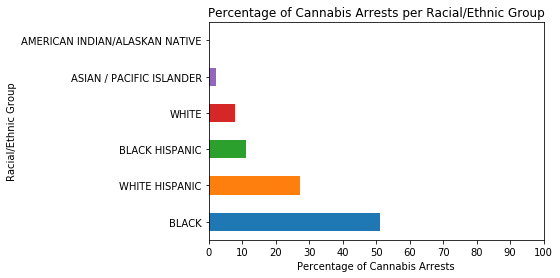

In [16]:
race_value_counts.plot(kind='barh', title='Percentage of Cannabis Arrests per Racial/Ethnic Group', xlim=(0, 100),
                      xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], color=current_palette)
plt.xlabel('Percentage of Cannabis Arrests')
plt.ylabel('Racial/Ethnic Group')
plt.show()

As can be seen below, a total of 84.3% of cannabis arrests with the suspect's race reported were made of people between the ages of 18-44.

In [17]:
age_value_counts = round(nyc_cann_rr['SUSP_AGE_GROUP_cleaned'].value_counts(normalize=True).sort_index(),3)*100
age_value_counts

18-24      40.2
25-44      44.1
45-64       8.2
65+         0.2
<18         6.2
unknown     1.0
Name: SUSP_AGE_GROUP_cleaned, dtype: float64

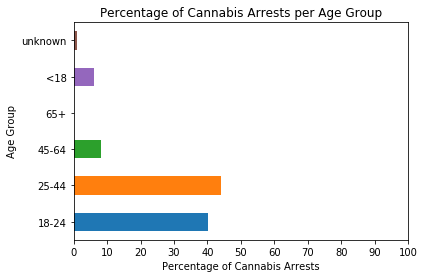

In [18]:
age_value_counts.plot(kind='barh', title='Percentage of Cannabis Arrests per Age Group', xlim=(0, 100),
                      xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                      color=current_palette)
plt.xlabel('Percentage of Cannabis Arrests')
plt.ylabel('Age Group')
plt.show()

As can be seen below, the vast majority (89.5%) of cannabis arrests where the suspect's race was reported are of males.

In [19]:
sex_value_counts = round(nyc_cann_rr['SUSP_SEX_cleaned'].value_counts(normalize=True),3)*100
sex_value_counts

M          89.5
F          10.4
unknown     0.1
Name: SUSP_SEX_cleaned, dtype: float64

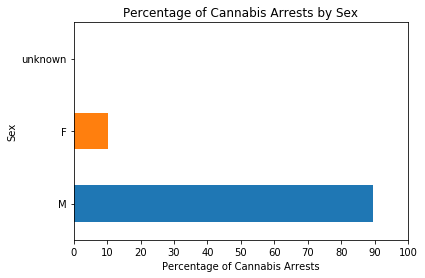

In [21]:
sex_value_counts.plot(kind='barh', title='Percentage of Cannabis Arrests by Sex', xlim=(0, 100),
                      xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                      color=current_palette)
plt.xlabel('Percentage of Cannabis Arrests')
plt.ylabel('Sex')
plt.show()

In order to better validate findings elsewhere reported that young African-American and Latino men make up the majority of cannabis arrests in New York City, a crosstabulation of race, age, and sex is run below on the cannabis cases where the suspect's race was reported.

In [20]:
pd.crosstab(nyc_cann_rr.SUSP_RACE_cleaned, [nyc_cann_rr.SUSP_AGE_GROUP_cleaned, nyc_cann_rr.SUSP_SEX_cleaned], normalize=True)

SUSP_AGE_GROUP_cleaned             18-24                         25-44                         45-64                           65+                 <18             unknown                    
SUSP_SEX_cleaned                       F         M   unknown         F         M   unknown         F         M   unknown         F         M         F         M         F         M   unknown
SUSP_RACE_cleaned                                                                                                                                                                             
AMERICAN INDIAN/ALASKAN NATIVE  0.000086  0.001033  0.000000  0.000029  0.000832  0.000000  0.000000  0.000086  0.000000  0.000000  0.000000  0.000029  0.000287  0.000000  0.000000  0.000029
ASIAN / PACIFIC ISLANDER        0.000746  0.011281  0.000000  0.000459  0.008468  0.000000  0.000000  0.000603  0.000000  0.000000  0.000000  0.000115  0.001579  0.000000  0.000086  0.000000
BLACK                           0.024399  0.160289  0.000029  0.022591  0.217613  0.000115  0.002957  0.047909  0.000029  0.000057  0.001464  0.003875  0.023222  0.000344  0.006057  0.000287
BLACK HISPANIC                  0.005081  0.046014  0.000000  0.003646  0.040761  0.000029  0.000316  0.006028  0.000000  0.000000  0.000144  0.000804  0.007492  0.000029  0.000775  0.000086
WHITE                           0.003014  0.030628  0.000000  0.003473  0.030973  0.000000  0.000660  0.004708  0.000000  0.000000  0.000258  0.000574  0.005425  0.000000  0.000316  0.000029
WHITE HISPANIC                  0.015415  0.104257  0.000086  0.011339  0.100755  0.000000  0.001234  0.017108  0.000000  0.000000  0.000574  0.002526  0.016104  0.000086  0.002153  0.000115

As can be seen in the above crosstabulation, 40.1% of cannabis arrests where the suspect's race was reported are of African-American males younger than 45, and 31.5% are of Hispanic males younger than 45, for a total of 71.6% of all cannabis arrests in New York City between 2006 and 2018 being of African-American and Hispanic males less than 45 years of age.

# Distribution of Types of Cannabis Crimes in New York City

One of the striking things about all cannabis arrests in New York City (not just those where the suspect's race was reported) are that the vast majority of them are for simple misdemeanor (89.5%) charges. This is seen in the following value count cells. Note that the PD_CD variable has been recoded to use text labels describing the various levels of cannabis crime: 566 for violation possession, 567 for misdemeanor possession, 568 for felony possession, 569 for misdemeanor sales, and 570 for felony sales. This is done for reporting and visualization purposes, as can be seen below in the object assignments and plotting of the five types of cannabis crime.

In [21]:
nyc_cann['PD_CD'] = nyc_cann['PD_CD'].astype(int)

In [22]:
nyc_cann['PD_CD'].value_counts()

567    197224
569     11426
566      6784
568      3755
570      1115
Name: PD_CD, dtype: int64

In [23]:
nyc_cann['PD_CD_recoded'] = nyc_cann['PD_CD'].map({566: 'Violation Possession', 567: 'Misdemeanor Possession', 568: 'Felony Possession', 569: 'Misdemeanor Sales', 570.0: 'Felony Sales'})

In [24]:
nyc_cann['PD_CD_recoded'].value_counts()

Misdemeanor Possession    197224
Misdemeanor Sales          11426
Violation Possession        6784
Felony Possession           3755
Felony Sales                1115
Name: PD_CD_recoded, dtype: int64

In [25]:
crime_types = round(nyc_cann['PD_CD_recoded'].value_counts(normalize=True), 3)*100
crime_types

Misdemeanor Possession    89.5
Misdemeanor Sales          5.2
Violation Possession       3.1
Felony Possession          1.7
Felony Sales               0.5
Name: PD_CD_recoded, dtype: float64

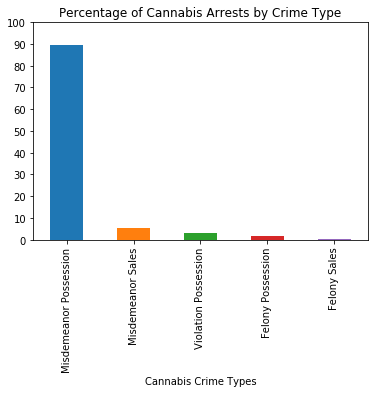

In [26]:
crime_types.plot(kind='bar', title='Percentage of Cannabis Arrests by Crime Type', ylim=(0, 100),
                      yticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                      color=current_palette)
plt.xlabel('Cannabis Crime Types')
plt.show()

It should be pointed out that violations are less serious than misdemeanor charges, as they only involve fines and do not go on one's criminal record; violations have been the primary tool used in cannabis arrests after the recent decriminalization (New York State Penal Law). 

# Distributions of Race Among Cannabis Crime Types

One of the aims of this project is to examine whether the racial disparity differs or remains consistent between the five levels of cannabis crime explored in this project. Suspect race value counts are run for each of the five levels of cannabis crime, as well as for possession crimes and sales crimes overall, for those cases with suspect race reported. This is done by creating smaller DataFrames by filtering the 'nyc_cann_rr' DataFrame on the five crime levels, as well as on possession and sales crimes on their own. Respectively, the seven smaller DataFrames are called 'nyc_cann_rr_mp' for misdemeanor possession, 'nyc_cann_rr_vp' for violation possession, 'nyc_cann_rr_fp' for felony possession, 'nyc_cann_rr_ms' for misdemeanor sales, 'nyc_cann_rr_fs' for felony sales, 'nyc_cann_rr_p' for possession overall, and 'nyc_cann_rr_s' for sales overall. Secondary objects are then assigned to the suspect race values for each of the seven crime type objects, which are finally plotted.


As can be seen below, the same racial disparity largely holds true across all five levels of cannabis crime, and for possession and sales crimes overall, with a few caveats. More violation possession arrests are made of white perpetrators than of black Hispanic suspects, but the difference is only 3%. Also, it should be noted that violation possession charges are the lowest level of cannabis arrests, and that the majority of violation possession charges are still of African-Americans and white Hispanics. 


More whites are arrested for felony possession charges than black Hispanics, but the differences is less than a percentage point. Also, the same amount of whites are arrested for felony sales charges as black Hispanics. But generally, racial groups are arrested for cannabis in the following descending order: African-Americans, White Hispanics, Black Hispanics, whites, Asians/Pacific Islanders, and American Indians/Alaskan Natives.

In [27]:
nyc_cann_rr_mp = nyc_cann_rr[nyc_cann_rr.misd_poss == 1]

In [28]:
misd_poss_race = round(nyc_cann_rr_mp['SUSP_RACE_cleaned'].value_counts(normalize=True),3)*100
misd_poss_race

BLACK                             50.8
WHITE HISPANIC                    27.6
BLACK HISPANIC                    11.1
WHITE                              8.1
ASIAN / PACIFIC ISLANDER           2.1
AMERICAN INDIAN/ALASKAN NATIVE     0.2
Name: SUSP_RACE_cleaned, dtype: float64

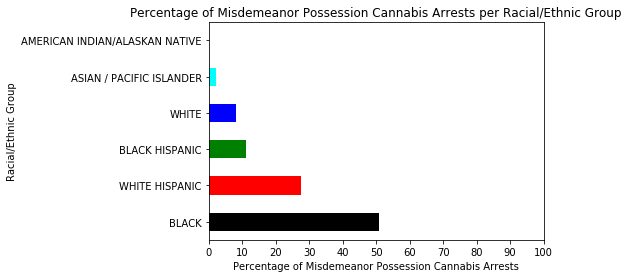

In [82]:
misd_poss_race.plot(kind='barh', title='Percentage of Misdemeanor Possession Cannabis Arrests per Racial/Ethnic Group', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['black', 'red', 'green', 'blue', 'cyan', 'magenta'])
plt.xlabel('Percentage of Misdemeanor Possession Cannabis Arrests')
plt.ylabel('Racial/Ethnic Group')
plt.show()

In [30]:
nyc_cann_rr_vp = nyc_cann_rr[nyc_cann_rr.viol_poss == 1]

In [31]:
viol_poss_race = round(nyc_cann_rr_vp['SUSP_RACE_cleaned'].value_counts(normalize=True),3)*100
viol_poss_race

BLACK                             60.5
WHITE HISPANIC                    20.2
WHITE                              9.7
BLACK HISPANIC                     6.7
ASIAN / PACIFIC ISLANDER           2.4
AMERICAN INDIAN/ALASKAN NATIVE     0.4
Name: SUSP_RACE_cleaned, dtype: float64

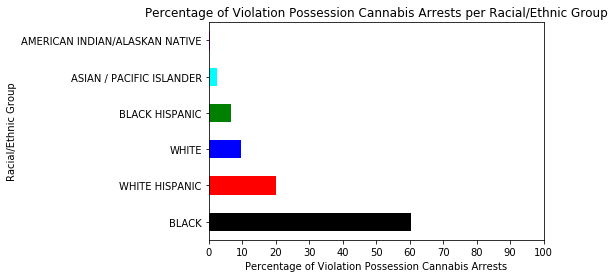

In [83]:
viol_poss_race.plot(kind='barh', title='Percentage of Violation Possession Cannabis Arrests per Racial/Ethnic Group', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['black', 'red', 'blue', 'green', 'cyan', 'magenta'])
plt.xlabel('Percentage of Violation Possession Cannabis Arrests')
plt.ylabel('Racial/Ethnic Group')
plt.show()

In [33]:
nyc_cann_rr_fp = nyc_cann_rr[nyc_cann_rr.felony_poss == 1]

In [34]:
felony_poss_race = round(nyc_cann_rr_fp['SUSP_RACE_cleaned'].value_counts(normalize=True),3)*100
felony_poss_race

BLACK                             46.3
WHITE HISPANIC                    26.2
WHITE                              9.9
BLACK HISPANIC                     9.4
ASIAN / PACIFIC ISLANDER           8.0
AMERICAN INDIAN/ALASKAN NATIVE     0.2
Name: SUSP_RACE_cleaned, dtype: float64

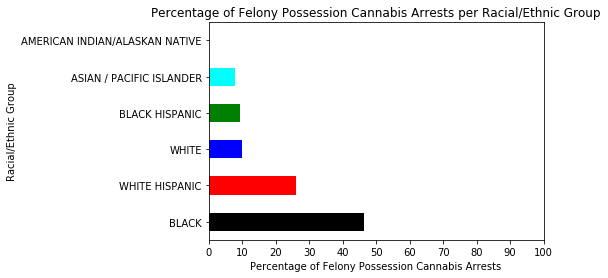

In [84]:
felony_poss_race.plot(kind='barh', title='Percentage of Felony Possession Cannabis Arrests per Racial/Ethnic Group', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['black', 'red', 'blue', 'green', 'cyan', 'magenta'])
plt.xlabel('Percentage of Felony Possession Cannabis Arrests')
plt.ylabel('Racial/Ethnic Group')
plt.show()

In [36]:
nyc_cann_rr_fp = nyc_cann_rr[nyc_cann_rr.misd_sales == 1]

In [37]:
misd_sales_race = round(nyc_cann_rr_fp['SUSP_RACE_cleaned'].value_counts(normalize=True),3)*100
misd_sales_race

BLACK                             52.7
WHITE HISPANIC                    25.8
BLACK HISPANIC                    14.8
WHITE                              3.9
ASIAN / PACIFIC ISLANDER           2.6
AMERICAN INDIAN/ALASKAN NATIVE     0.2
Name: SUSP_RACE_cleaned, dtype: float64

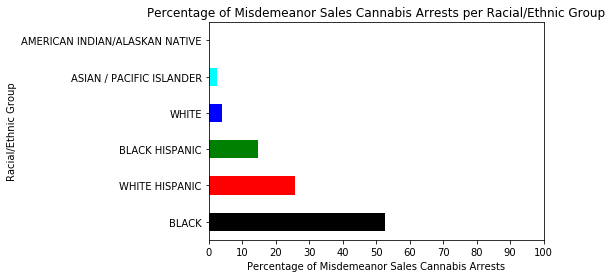

In [85]:
misd_sales_race.plot(kind='barh', title='Percentage of Misdemeanor Sales Cannabis Arrests per Racial/Ethnic Group', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['black', 'red', 'green', 'blue', 'cyan', 'magenta'])
plt.xlabel('Percentage of Misdemeanor Sales Cannabis Arrests')
plt.ylabel('Racial/Ethnic Group')
plt.show()

In [39]:
nyc_cann_rr_fs = nyc_cann_rr[nyc_cann_rr.felony_sales == 1]

In [40]:
felony_sales_race = round(nyc_cann_rr_fs['SUSP_RACE_cleaned'].value_counts(normalize=True),3)*100
felony_sales_race

BLACK                             52.0
WHITE HISPANIC                    27.7
BLACK HISPANIC                     7.4
WHITE                              7.4
ASIAN / PACIFIC ISLANDER           5.0
AMERICAN INDIAN/ALASKAN NATIVE     0.5
Name: SUSP_RACE_cleaned, dtype: float64

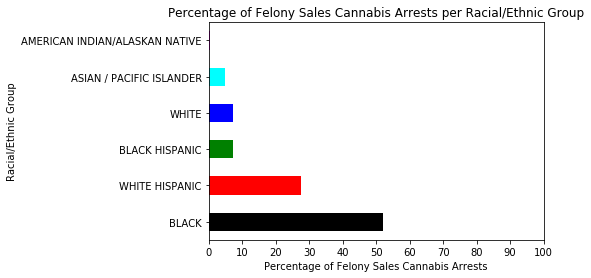

In [86]:
felony_sales_race.plot(kind='barh', title='Percentage of Felony Sales Cannabis Arrests per Racial/Ethnic Group', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['black', 'red', 'green', 'blue', 'cyan', 'magenta'])
plt.xlabel('Percentage of Felony Sales Cannabis Arrests')
plt.ylabel('Racial/Ethnic Group')
plt.show()

In [42]:
nyc_cann_rr_p = nyc_cann_rr[nyc_cann_rr.possession == 1]

In [43]:
possession_race = round(nyc_cann_rr_p['SUSP_RACE_cleaned'].value_counts(normalize=True),3)*100
possession_race

BLACK                             51.0
WHITE HISPANIC                    27.3
BLACK HISPANIC                    10.9
WHITE                              8.2
ASIAN / PACIFIC ISLANDER           2.3
AMERICAN INDIAN/ALASKAN NATIVE     0.2
Name: SUSP_RACE_cleaned, dtype: float64

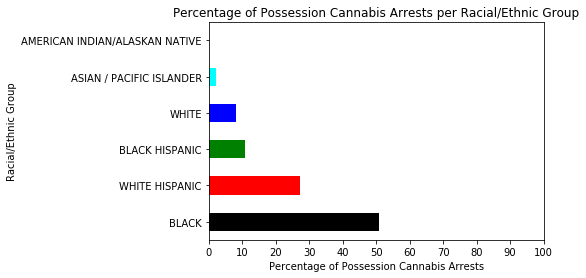

In [87]:
possession_race.plot(kind='barh', title='Percentage of Possession Cannabis Arrests per Racial/Ethnic Group', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['black', 'red', 'green', 'blue', 'cyan', 'magenta'])
plt.xlabel('Percentage of Possession Cannabis Arrests')
plt.ylabel('Racial/Ethnic Group')
plt.show()

In [45]:
nyc_cann_rr_s = nyc_cann_rr[nyc_cann_rr.sales == 1]

In [46]:
sales_race = round(nyc_cann_rr_s['SUSP_RACE_cleaned'].value_counts(normalize=True),3)*100
sales_race

BLACK                             52.6
WHITE HISPANIC                    26.0
BLACK HISPANIC                    14.1
WHITE                              4.3
ASIAN / PACIFIC ISLANDER           2.8
AMERICAN INDIAN/ALASKAN NATIVE     0.2
Name: SUSP_RACE_cleaned, dtype: float64

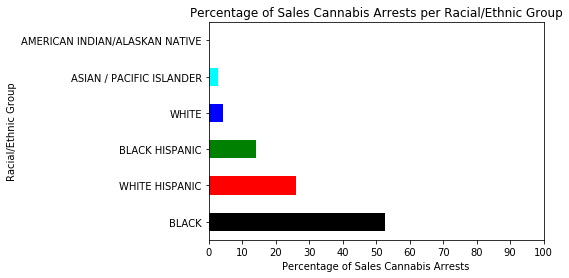

In [88]:
sales_race.plot(kind='barh', title='Percentage of Sales Cannabis Arrests per Racial/Ethnic Group', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['black', 'red', 'green', 'blue', 'cyan', 'magenta'])
plt.xlabel('Percentage of Sales Cannabis Arrests')
plt.ylabel('Racial/Ethnic Group')
plt.show()

# Other Indicators of Bias in Cannabis Arrests

To look at other indicators of bias in cannabis arrests in New York City, five DataFrames are first made from the full DataFrame of all cannabis crimes (not just those with the suspect's race reported), one for each of the cannabis crime types: misdemeanor possession, violation possession, felony possession, misdemeanor sales, and felony sales. DataFrames are also made for possession and sales crimes overall.

In [48]:
nyc_cann_mp = nyc_cann[nyc_cann.misd_poss == 1]

In [49]:
nyc_cann_vp = nyc_cann[nyc_cann.viol_poss == 1]

In [50]:
nyc_cann_fp = nyc_cann[nyc_cann.felony_poss == 1]

In [51]:
nyc_cann_ms = nyc_cann[nyc_cann.misd_sales == 1]

In [52]:
nyc_cann_fs = nyc_cann[nyc_cann.felony_sales == 1]

In [53]:
nyc_cann_p = nyc_cann[nyc_cann.possession == 1]

In [54]:
nyc_cann_s = nyc_cann[nyc_cann.sales == 1]

# Mapping Concentrations of Cannabis Arrests

The concentration of cannabis arrests in different geographic sections of New York City can help us identify where New Yorkers are arrested for cannabis. The most fundamental geographic measurement in the NYPD's dataset is latitude and longitude, which is visualized in a scatter plot of cannabis arrests below. The visual concentration of arrests in certain parts of the city will help us partially infer race in the overall DataFrame of cannabis crimes due to the concentration of different demographic populations in different sections of the city, even though only 16% of cases have the suspects' race reported.

First, a simple image of New York City is called for reference. Then, the scatterplot is overlaid on the map of New York City.

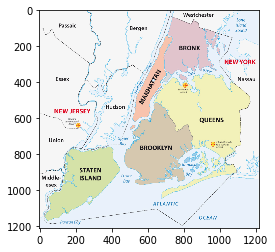

In [55]:
im = plt.imread("map_of_nyc.png")
implot = plt.imshow(im)

As can be seen, arrests were greatly concentrated in Manhattan, the Bronx, an area of Queens around LaGuardia Airport, northern Staten Island, northern Brooklyn, eastern Brooklyn, central Brooklyn, and to a lesser degree southern Brooklyn.

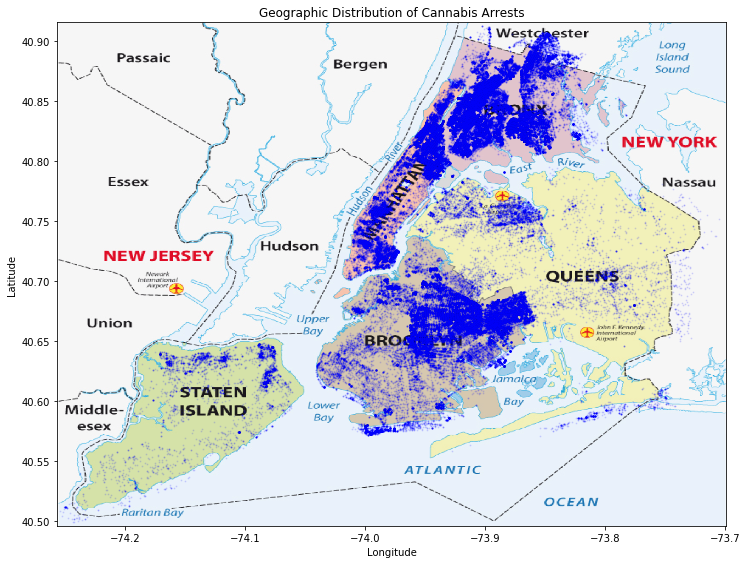

In [57]:
ax = nyc_cann.plot(x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='b', s=1, alpha=0.1, title='Geographic Distribution of Cannabis Arrests')
plt.imshow(im, zorder=0, extent=[-74.257159, -73.699215, 40.495992, 40.915568])

It would be interesting to see this scatter-plot/map of cannabis arrests for the five crime types. First, possession crimes are mapped. Misdemeanor possession crimes are plotted in cyan, violation possession crimes are plotted in red, and felony possession crimes are plotted in magenta.

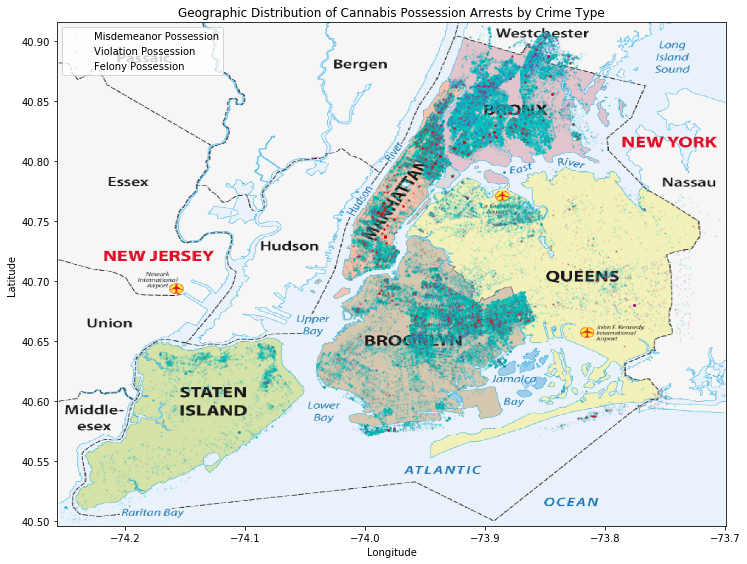

In [58]:
ax = nyc_cann_mp.plot(x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='c', s=1, alpha=0.1, title='Geographic Distribution of Cannabis Possession Arrests by Crime Type')
ax = nyc_cann_vp.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='r', s=1, alpha=0.1)
ax = nyc_cann_fp.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='m', s=1, alpha=0.1)
plt.legend(('Misdemeanor Possession', 'Violation Possession', 'Felony Possession'), loc='upper left')
plt.imshow(im, zorder=0, extent=[-74.257159, -73.699215, 40.495992, 40.915568])
plt.savefig('map_of_cannabis_possession_charges.png')

As can be seen above, the vast majority of cannabis possession arrests are for misdemeanor possession, and are heavily concentrated in the Bronx, Inwood, Washington Heights, and Harlem, which have large populations of African-American and Latino residents. In Brooklyn, arrests are concentrated in neighborhoods like East New York, Cypress Hills, Brownsville, Crown Heights, Flatbush, Bedford-Stuyvesant, and Bushwick. Again, these neighborhoods have large populations of African-American and Latino residents. Violation and felony possession are peppered throughout, but they are concentrated in the neighborhoods already mentioned.  Manhattan, Queens, south and west Brooklyn, and Staten Island have significantly fewer arrests. It bears mentioning that Staten Island is majority white, and the clusters of arrests there are centered around housing projects like Stapleton and Park Hill. 

Because sales are so different than simple possession, and for ease of visualization, cannabis sales are visualized separately below. One can see below that these arrests tend to fall within the same neighborhoods as possession arrests. Misdemeanor sales crimes are plotted in yellow and felony sales crimes are plotted in black.

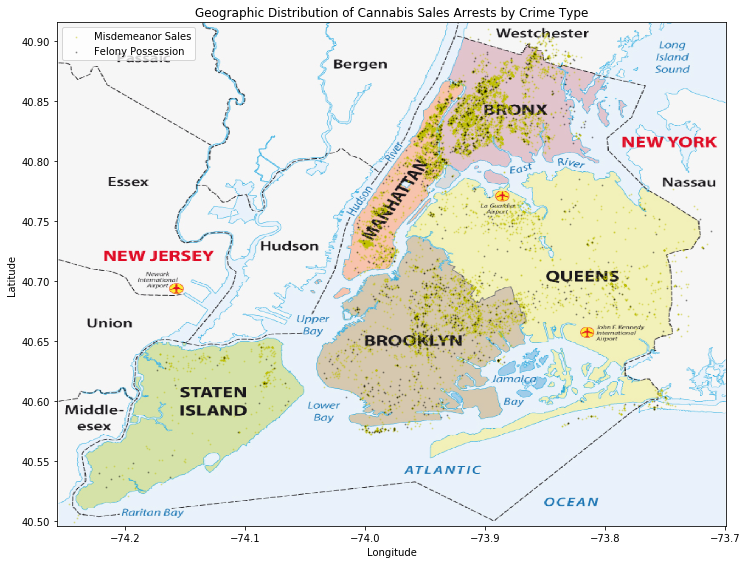

In [59]:
ax = nyc_cann_ms.plot(x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='y', s=1, alpha=0.3, title='Geographic Distribution of Cannabis Sales Arrests by Crime Type')
ax = nyc_cann_fs.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='k', s=1, alpha=0.3)
plt.legend(('Misdemeanor Sales', 'Felony Possession'), loc='upper left')
plt.imshow(im, zorder=0, extent=[-74.257159, -73.699215, 40.495992, 40.915568])
plt.savefig('map_of_cannabis_sales_charges.png')

All possession and sales crimes are displayed below on the same scatterplot. Possession crimes are plotted in cyan, and sales crimes are plotted in yellow. It can be seen clearly that sales arrests are largely concentrated in uptown Manhattan and the Bronx, with pockets around the transit hub of Midtown, the West Village, and scattered points in Central and Eastern Brooklyn.

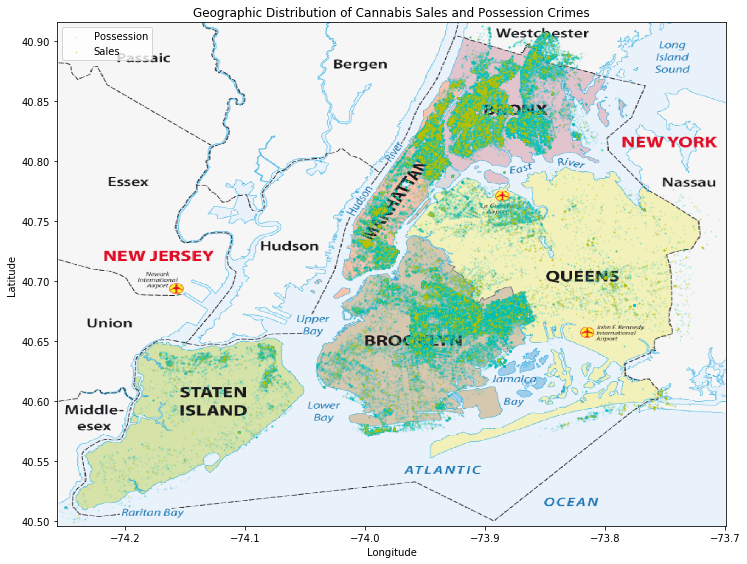

In [60]:
ax = nyc_cann_p.plot(x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='c', s=1, alpha=0.1, title='Geographic Distribution of Cannabis Sales and Possession Crimes')
ax = nyc_cann_s.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='y', s=1, alpha=0.3)
plt.legend(('Possession', 'Sales'), loc='upper left')
plt.imshow(im, zorder=0, extent=[-74.257159, -73.699215, 40.495992, 40.915568])
plt.savefig('map_of_possession_v_sales.png')

Visualizing the locations of cannabis arrests and non-cannabis arrests on the same plot could also be illustrative. In order to do so, the EDA versions of the cannabis and non-cannabis crime DataFrames are first concatenated and a 'cannabis_crime' feature is added to differentiate cannabis crimes from non-cannabis crimes. As a reminder, the EDA version of the non-cannabis DataFrame is a sample of all non-cannabis crimes with the same sample size as the universe of cannabis crimes (n=220,304).

In [61]:
nyc_non_cann = pd.read_csv("nyc_non_cann_sample.csv", index_col=0)

In [62]:
nyc_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,possession,sales,misdemeanor,violation,felony,misd_poss,viol_poss,felony_poss,misd_sales,viol_sales,felony_sales,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,SUSP_AGE_GROUP_cleaned,SUSP_RACE_cleaned,SUSP_SEX_cleaned,VIC_AGE_GROUP_cleaned,VIC_RACE_cleaned,VIC_SEX_cleaned,PD_CD_recoded
148,498164466,12/31/2018,21:55:00,62.0,12/31/2018,235,DANGEROUS DRUGS,567,"MARIJUANA, POSSESSION 4 & 5",COMPLETED,MISDEMEANOR,BROOKLYN,unknown,STREET,N.Y. POLICE DEPT,unknown,not_housing_devpt_crime,979947.0,160366.0,not_transit_related,40.606851,-74.015498,"(40.60685112, -74.015498354)",PATROL BORO BKLYN SOUTH,not_transit_related,1,0,1,0,0,1,0,0,0,0,0,2018-12-31 21:55:00,0,2018,12,31,21,55,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.019211,0.017145,0.107947,0.104259,0.117847,0.115347,0.125347,0.149847,0.142147,0.153447,0.165747,0.181147,0.188647,0.171347,0.197647,0.226147,0.268547,0.312047,0.319947,0.341947,0.099847,0.120247,0.092092,0.175247,0.118847,0.064747,0.315747,0.121047,0.10587,0.100115,0.100976,0.106365,0.103635,0.115121,0.125278,0.131335,0.145422,0.154097,0.156244,0.144651,0.168711,0.183038,0.213416,0.239982,0.226654,0.251772,0.070769,0.094479,0.070471,0.15215,0.106124,0.054323,0.226845,0.108393,25-44,BLACK HISPANIC,M,unknown,unknown,unknown,Misdemeanor Possession


In [63]:
nyc_non_cann.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,date_time_start,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,SUSP_AGE_GROUP_cleaned,SUSP_RACE_cleaned,SUSP_SEX_cleaned,VIC_AGE_GROUP_cleaned,VIC_RACE_cleaned,VIC_SEX_cleaned,closest_subway_distance_l1,closest_subway_distance_l2
3019980,260056435,09/02/2012,21:00:00,43.0,09/02/2012,105,ROBBERY,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",COMPLETED,FELONY,BRONX,unknown,STREET,N.Y. POLICE DEPT,unknown,not_housing_devpt_crime,1025261.0,238703.0,not_transit_related,40.821773,-73.851826,"(40.821773241, -73.851826496)",PATROL BORO BRONX,not_transit_related,2012-09-02 21:00:00,0,2012.0,9.0,2.0,21.0,0.0,0.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.270647,0.274335,0.260747,0.263247,0.253247,0.228747,0.236447,0.225147,0.212847,0.197447,0.189947,0.207247,0.180947,0.152447,0.110047,0.0822,0.0707,0.1505,0.278747,0.258347,0.340496,0.203347,0.259747,0.313847,0.062847,0.257547,0.194944,0.196524,0.185544,0.18888,0.179922,0.161986,0.171577,0.163619,0.158547,0.148107,0.141687,0.152662,0.140591,0.120042,0.098976,0.074784,0.064953,0.109529,0.199588,0.182746,0.242493,0.152916,0.185877,0.222034,0.044609,0.184611,unknown,BLACK,M,<18,WHITE HISPANIC,M,0.01235,0.01232


In [64]:
nyc_cnc = pd.concat([nyc_cann, nyc_non_cann], sort=True)

In [65]:
nyc_cann.shape

(220304, 138)

In [66]:
nyc_non_cann.shape

(220304, 126)

In [67]:
nyc_cnc.shape

(440608, 138)

In [68]:
nyc_cnc.head(1)

,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_NUM,CRM_ATPT_CPTD_CD,HADEVELOPT,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,Lat_Lon,Latitude,Longitude,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_CD_recoded,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP_cleaned,SUSP_RACE_cleaned,SUSP_SEX_cleaned,TRANSIT_DISTRICT,VIC_AGE_GROUP_cleaned,VIC_RACE_cleaned,VIC_SEX_cleaned,X_COORD_CD,Y_COORD_CD,apollo_th_l1,apollo_th_l2,bk_bridge_l1,bk_bridge_l2,central_pk_l1,central_pk_l2,christmas,christmas_eve,city_hall_l1,city_hall_l2,closest_subway_distance_l1,closest_subway_distance_l2,date_time_start,day_tw,dinner,diwali,downtown_bk_l1,downtown_bk_l2,duration_days,early_morn,easter,eid_al_adha,eid_al_fitr,empire_st_bldg_l1,empire_st_bldg_l2,eve_rush_hr,evening,felony,felony_poss,felony_sales,four_twenty,halloween,hanukkah,july_4th,labor_day,late_night,lincoln_ctr_l1,lincoln_ctr_l2,lunch_hr,manh_bridge_l1,manh_bridge_l2,mdc_l1,mdc_l2,memorial_day,mets_stad_l1,mets_stad_l2,misd_poss,misd_sales,misdemeanor,mlk,morn_rush_hr,new_years_day,new_years_eve,night_tw,nypd_hq_l1,nypd_hq_l2,nysc_l1,nysc_l2,nyse_l1,nyse_l2,penn_station_l1,penn_station_l2,port_authority_l1,port_authority_l2,possession,pr_parade,pres,prospect_pk_l1,prospect_pk_l2,queens_l1,queens_l2,rikers_l1,rikers_l2,rock_center_l1,rock_center_l2,rosh_hashanah,rpt_cmplnt_dt_match,sales,si_ferry_l1,si_ferry_l2,st_patricks,start_day,start_hour,start_minute,start_month,start_seconds,start_year,thanksgiving,times_sq_l1,times_sq_l2,union_sq_l1,union_sq_l2,valentines,viol_poss,viol_sales,violation,wash_sq_park_l1,wash_sq_park_l2,will_bridge_l1,will_bridge_l2,work_day,wtc_l1,wtc_l2,yankee_stad_l1,yankee_stad_l2,yomkippur
148,62.0,BROOKLYN,12/31/2018,21:55:00,498164466,COMPLETED,not_housing_devpt_crime,N.Y. POLICE DEPT,235,MISDEMEANOR,unknown,"(40.60685112, -74.015498354)",40.606851,-74.015498,DANGEROUS DRUGS,unknown,PATROL BORO BKLYN SOUTH,567.0,Misdemeanor Possession,"MARIJUANA, POSSESSION 4 & 5",STREET,12/31/2018,not_transit_related,25-44,BLACK HISPANIC,M,not_transit_related,unknown,unknown,unknown,979947.0,160366.0,0.268547,0.213416,0.117847,0.100976,0.226147,0.183038,0,0,0.115347,0.106365,0.019211,0.017145,2018-12-31 21:55:00,0,0,0,0.120247,0.094479,0,0,0,0,0,0.171347,0.144651,0,1,0.0,0.0,0.0,0,0,0,0,0,0,0.197647,0.168711,0,0.125347,0.103635,0.064747,0.054323,0,0.319947,0.226654,1.0,0.0,1.0,0,0,0,1,1,0.118847,0.106124,0.121047,0.108393,0.104259,0.100115,0.165747,0.145422,0.175247,0.15215,1.0,0,0,0.099847,0.070769,0.341947,0.251772,0.315747,0.226845,0.188647,0.156244,0,1,0.0,0.092092,0.070471,0,31.0,21.0,55.0,12.0,0.0,2018.0,0,0.181147,0.154097,0.153447,0.131335,0,0.0,0.0,0.0,0.142147,0.125278,0.149847,0.115121,0,0.107947,0.10587,0.312047,0.239982,0


The presence of duplicate cases in the concatenated DataFrame is then checked for again.

In [69]:
nyc_cnc = nyc_cnc.drop_duplicates()
nyc_cnc.shape

(440608, 138)

In [70]:
cannabis_crime = (nyc_cnc.PD_CD >= 566.0) & (nyc_cnc.PD_CD <= 570.0)

In [71]:
nyc_cnc['cannabis_crime'] = cannabis_crime.astype(int)
nyc_cnc['cannabis_crime'].value_counts()

1    220304
0    220304
Name: cannabis_crime, dtype: int64

In [72]:
nyc_c = nyc_cnc[nyc_cnc.cannabis_crime == 1]
nyc_n = nyc_cnc[nyc_cnc.cannabis_crime == 0]

All cannabis and non-cannabis crimes are displayed below on the same scatterplot. Cannabis crimes are plotted in red, and non-cannabis crimes are plotted in cyan. It can be seen clearly that against the background of all other crimes, cannabis crimes are largely concentrated in the Bronx (especially around Throggs Neck and the East Bronx) and Central Brooklyn (especially around East New York, Flatbush, and Brownsville).

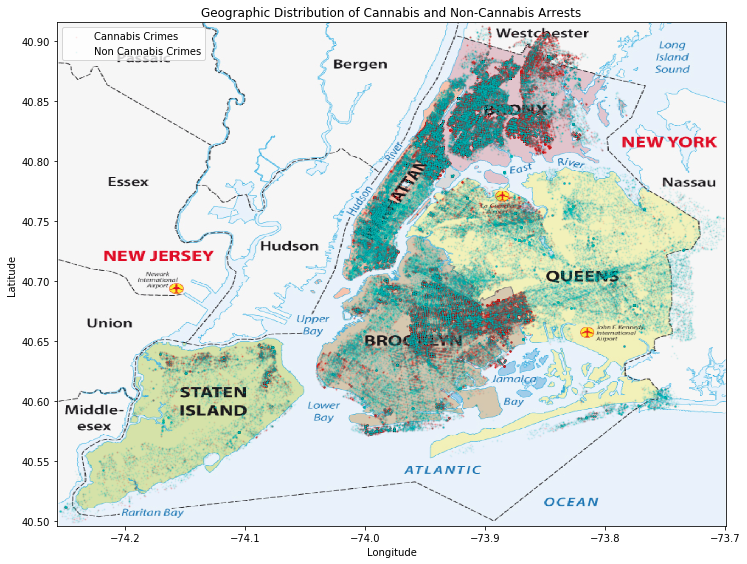

In [73]:
ax = nyc_c.plot(x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='r', s=1, alpha=0.05, title='Geographic Distribution of Cannabis and Non-Cannabis Arrests')
ax = nyc_n.plot(ax=ax, x='Longitude', y='Latitude', kind='scatter', figsize=(12, 12), c='c', s=1, alpha=0.05)
plt.legend(('Cannabis Crimes', 'Non Cannabis Crimes'), loc='upper left')
plt.imshow(im, zorder=0, extent=[-74.257159, -73.699215, 40.495992, 40.915568])
plt.savefig('map_of_cannabis_v_non-cannabis.png')

# Borough

The first geographic indicator of New York City is the borough. As can be seen in overall cannabis arrests, the Bronx and Brooklyn are home to the majority of them. This is interesting because of the racial and ethnic demographics of these two boroughs. Looking at the Census data estimated from 2018 and 2019 shows us the following racial and ethnic breakdown by borough. It is important to remember that Hispanic/Latino status is considered as an ethnicity, and people of any racial group (Black or African-American, White, Asian, Native Hawaiian/Pacific Islander, and American Indian/Alaskan Native) can also be of Hispanic/Latino ethnicity.

The Bronx's populace is 44% African-American, 56% Latino/Hispanic, 5% Asian and only 9% non-Latino White, while Brooklyn's populace is 34% African-American, 19% Latino/Hispanic, 13% Asian, and 36% non-Latino White. By contrast, Manhattan's populace is 18% black, 26% Latino/Hispanic, 13% Asian, and 47% non-Latino white. Queens is 21% black, 28% Latino/Hispanic, 25% non-Latino white, and 27% Asian. Staten Island is 12% black, 19% Latino/Hispanic, and 60% non-Latino white ("Census Bureau Quick Facts on New York City").

In [74]:
nyc_borough = round(nyc_cann['BORO_NM'].value_counts(normalize=True), 3)*100
nyc_borough

BRONX            39.4
BROOKLYN         32.4
MANHATTAN        21.1
QUEENS            4.4
STATEN ISLAND     2.6
unknown           0.1
Name: BORO_NM, dtype: float64

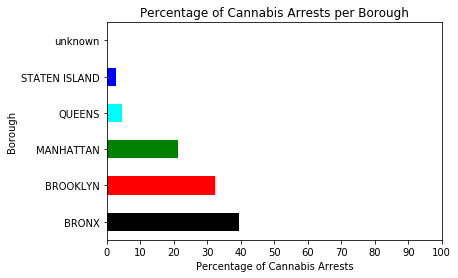

In [89]:
nyc_borough.plot(kind='barh', title='Percentage of Cannabis Arrests per Borough', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['black', 'red', 'green', 'cyan', 'blue'])
plt.xlabel('Percentage of Cannabis Arrests')
plt.ylabel('Borough')
plt.show()

Misdemeanor and felony possession charges are dominant in the Bronx and Brooklyn, while violation possession charges (the lowest level of cannabis crimes) are dominant in Manhattan. This supports the idea that cannabis crimes are punished very differently in New York City dependent on which part of the city the crime takes place in.

In [76]:
misd_poss_nyc_borough = round(nyc_cann_mp['BORO_NM'].value_counts(normalize=True),3)*100
misd_poss_nyc_borough

BRONX            40.3
BROOKLYN         32.9
MANHATTAN        20.4
QUEENS            3.7
STATEN ISLAND     2.6
unknown           0.1
Name: BORO_NM, dtype: float64

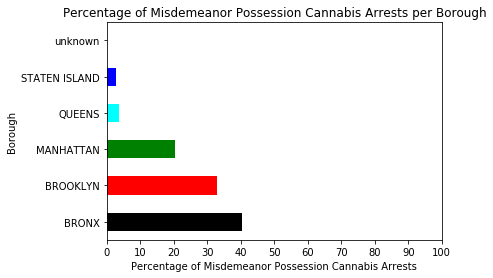

In [90]:
misd_poss_nyc_borough.plot(kind='barh', title='Percentage of Misdemeanor Possession Cannabis Arrests per Borough', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['black', 'red', 'green', 'cyan', 'blue'])
plt.xlabel('Percentage of Misdemeanor Possession Cannabis Arrests')
plt.ylabel('Borough')
plt.show()

In [78]:
viol_poss_nyc_borough = round(nyc_cann_vp['BORO_NM'].value_counts(normalize=True),3)*100
viol_poss_nyc_borough

MANHATTAN        35.5
BROOKLYN         34.0
BRONX            20.5
QUEENS            8.8
STATEN ISLAND     1.1
unknown           0.1
Name: BORO_NM, dtype: float64

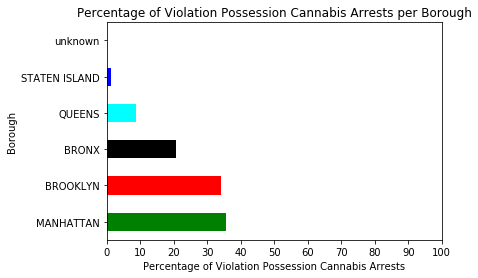

In [79]:
viol_poss_nyc_borough.plot(kind='barh', title='Percentage of Violation Possession Cannabis Arrests per Borough', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['green', 'red', 'black', 'cyan', 'blue'])
plt.xlabel('Percentage of Violation Possession Cannabis Arrests')
plt.ylabel('Borough')
plt.show()

In [80]:
felony_poss_nyc_borough = round(nyc_cann_fp['BORO_NM'].value_counts(normalize=True),3)*100
felony_poss_nyc_borough

BRONX            34.1
BROOKLYN         32.8
MANHATTAN        16.1
QUEENS           15.0
STATEN ISLAND     1.9
unknown           0.1
Name: BORO_NM, dtype: float64

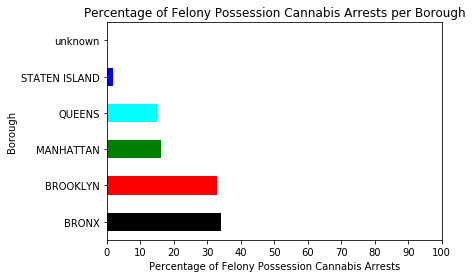

In [81]:
felony_poss_nyc_borough.plot(kind='barh', title='Percentage of Felony Possession Cannabis Arrests per Borough', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['black', 'red', 'green', 'cyan', 'blue'])
plt.xlabel('Percentage of Felony Possession Cannabis Arrests')
plt.ylabel('Borough')
plt.show()

In overall possession arrests, the Bronx and Brooklyn predominate, with Manhattan a distant third. Queens and Staten Island have barely any possession arrests.

In [82]:
possession_nyc_borough = round(nyc_cann_p['BORO_NM'].value_counts(normalize=True), 3)*100
possession_nyc_borough

BRONX            39.5
BROOKLYN         33.0
MANHATTAN        20.8
QUEENS            4.1
STATEN ISLAND     2.5
unknown           0.1
Name: BORO_NM, dtype: float64

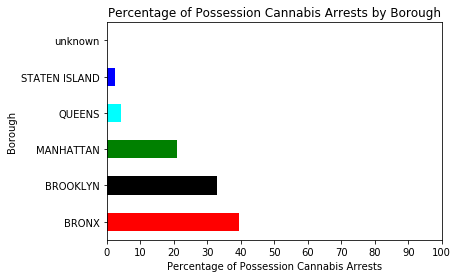

In [83]:
possession_nyc_borough.plot(kind='barh', title='Percentage of Possession Cannabis Arrests by Borough', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['red', 'black', 'green', 'cyan', 'blue'])
plt.xlabel('Percentage of Possession Cannabis Arrests')
plt.ylabel('Borough')
plt.show()

Intriguingly, Manhattan has more misdemeanor sales arrests than Brooklyn. This may be due to a large amount of small cannabis sales occurring in Manhattan. It would be interesting to see which neighborhoods of Manhattan are responsible for this.

In [84]:
misd_sales_nyc_borough = round(nyc_cann_ms['BORO_NM'].value_counts(normalize=True),3)*100
misd_sales_nyc_borough

BRONX            38.5
MANHATTAN        27.3
BROOKLYN         22.2
QUEENS            8.7
STATEN ISLAND     3.2
unknown           0.1
Name: BORO_NM, dtype: float64

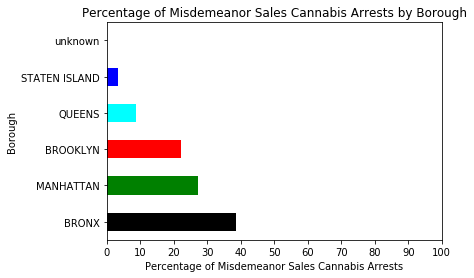

In [85]:
misd_sales_nyc_borough.plot(kind='barh', title='Percentage of Misdemeanor Sales Cannabis Arrests by Borough', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['black', 'green', 'red', 'cyan', 'blue'])
plt.xlabel('Percentage of Misdemeanor Sales Cannabis Arrests')
plt.ylabel('Borough')
plt.show()

In [86]:
felony_sales_nyc_borough = round(nyc_cann_fs['BORO_NM'].value_counts(normalize=True), 3)*100
felony_sales_nyc_borough

BROOKLYN         34.1
BRONX            30.0
MANHATTAN        20.0
QUEENS           12.9
STATEN ISLAND     2.9
unknown           0.2
Name: BORO_NM, dtype: float64

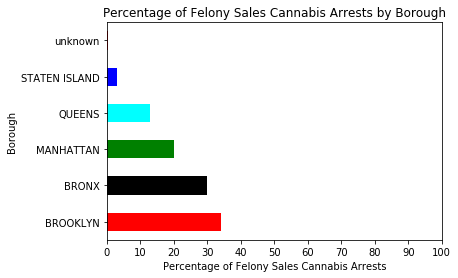

In [87]:
felony_sales_nyc_borough.plot(kind='barh', title='Percentage of Felony Sales Cannabis Arrests by Borough', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['red', 'black', 'green', 'cyan', 'blue'])
plt.xlabel('Percentage of Felony Sales Cannabis Arrests')
plt.ylabel('Borough')
plt.show()

Brooklyn and the Bronx predominate for felony sales; again, it would be interesting to see which neighborhoods are responsible for these arrests. Police precincts offer a route to explore these smaller geographic zones.

For overall sales arrests, the Bronx has a dominant majority with 37.7% of the arrests. Manhattan and Brooklyn are close to each other at 26.7% and 23.3% respectively, but Queens and especially Staten Island have very few arrests.

In [88]:
sales_nyc_borough = round(nyc_cann_s['BORO_NM'].value_counts(normalize=True), 3)*100
sales_nyc_borough

BRONX            37.7
MANHATTAN        26.7
BROOKLYN         23.3
QUEENS            9.1
STATEN ISLAND     3.1
unknown           0.1
Name: BORO_NM, dtype: float64

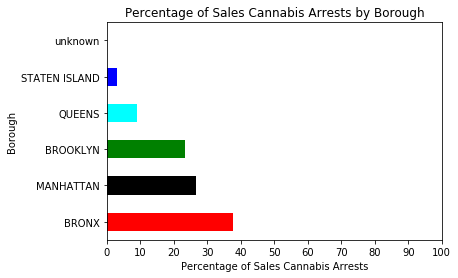

In [89]:
sales_nyc_borough.plot(kind='barh', title='Percentage of Sales Cannabis Arrests by Borough', 
                    xlim=(0, 100), xticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                    color=['red', 'black', 'green', 'cyan', 'blue'])
plt.xlabel('Percentage of Sales Cannabis Arrests')
plt.ylabel('Borough')
plt.show()

# Police Precincts

Unfortunately, the precinct data was unlabeled in the dataset downloaded from the NYC Open Data project. However, after consulting the NYPD's website (https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page ),  the top 10 precincts for cannabis arrests are:

43rd Precinct - Southeastern Bronx

75th Precinct - Easternmost Brooklyn (East New York and Cypress Hills)

44th Precinct - Southwestern Bronx

73rd Precinct - Northeastern Brooklyn (Brownsville and Ocean Hill)

46th Precinct - Central West Bronx (Fordham, University Heights, Morris Heights and Mount Hope)

40th Precinct - Southernmost Bronx (Port Morris, Mott Haven, and Melrose)

47th Precinct - Northern Bronx (Woodlawn, Wakefield, Williamsbridge, Baychester, Edenwald, Olinville, Fishbay, and Woodlawn Cemetary)

52nd Precinct - Northern Bronx section (Bedford Park, Fordham, Kingsbridge, Norwood, Bronx Park, and University Heights)

42nd Precinct - Morrisania section of the Bronx (Claremont, Crotona Park East, and Crotona Park)

67th Precinct - Central Brooklyn (East Flatbush and Remsen Village)

As can be seen, the top 10 police precincts with the highest amounts of cannabis arrests are all in the Bronx and Brooklyn. The demographics in these neighborhoods reflects the racial disparity seen in cannabis arrests.

There is also a Patrol Borough feature, as the NYPD splits the boroughs up into a few different patrol boroughs. Value counts for Patrol Borough are included after each precinct code value count call.

In [90]:
round(nyc_cann['ADDR_PCT_CD'].value_counts(normalize=True).head(10), 3)*100

43.0    7.5
75.0    7.1
44.0    5.6
73.0    4.6
46.0    4.4
40.0    4.3
47.0    4.3
52.0    4.1
42.0    3.5
67.0    2.8
Name: ADDR_PCT_CD, dtype: float64

In [91]:
round(nyc_cann['PATROL_BORO'].value_counts(normalize=True), 3)*100

PATROL BORO BRONX            39.5
PATROL BORO BKLYN NORTH      19.8
PATROL BORO MAN NORTH        14.1
PATROL BORO BKLYN SOUTH      12.6
PATROL BORO MAN SOUTH         7.1
PATROL BORO QUEENS NORTH      3.1
PATROL BORO STATEN ISLAND     2.6
PATROL BORO QUEENS SOUTH      1.3
unknown                       0.0
Name: PATROL_BORO, dtype: float64

The only difference for the DataFrame of just misdemeanor possession charges is that the 77th precinct takes the 10th place spot. This precinct is found in the northern section of the Crown Heights neighborhood of Brooklyn, an area mostly occupied by African-Americans of Caribbean descent.

In [92]:
round(nyc_cann_mp['ADDR_PCT_CD'].value_counts(normalize=True).head(10), 3)*100

43.0    7.9
75.0    7.4
44.0    5.7
73.0    4.7
46.0    4.5
40.0    4.4
47.0    4.3
52.0    4.1
42.0    3.6
77.0    2.9
Name: ADDR_PCT_CD, dtype: float64

In [93]:
round(nyc_cann_mp['PATROL_BORO'].value_counts(normalize=True), 3)*100

PATROL BORO BRONX            40.3
PATROL BORO BKLYN NORTH      20.3
PATROL BORO MAN NORTH        13.8
PATROL BORO BKLYN SOUTH      12.7
PATROL BORO MAN SOUTH         6.6
PATROL BORO QUEENS NORTH      2.9
PATROL BORO STATEN ISLAND     2.6
PATROL BORO QUEENS SOUTH      0.9
unknown                       0.0
Name: PATROL_BORO, dtype: float64

As reflected above, the precinct with the most violation possession charges (the 14th) is in Manhattan in Midtown South, which encompasses the Port Authority Bus Terminal, Penn Station, and Times Square. This finding is also supported by the fact that the station with the largest amount of transit-related cannabis arrests is the Port Authority Bus Terminal. The other two Manhattan precincts in the top 10 (the 13th and the 18th) for violation possession are also in Midtown. The 71st precinct is in central Brooklyn, encompassing the southern portion of Crown Heights, Wingate, and Prospect Lefferts. But one can clearly see from this data how violation possession charges are more frequently used in Manhattan, while misdemeanor possession charges are more frequently used in the Bronx and Brooklyn.

In [94]:
round(nyc_cann_vp['ADDR_PCT_CD'].value_counts(normalize=True).head(10), 3)*100

14.0    6.8
75.0    5.9
73.0    4.3
40.0    3.7
43.0    3.6
71.0    3.2
13.0    3.1
25.0    2.9
18.0    2.8
67.0    2.6
Name: ADDR_PCT_CD, dtype: float64

In [95]:
round(nyc_cann_vp['PATROL_BORO'].value_counts(normalize=True), 3)*100

PATROL BORO BRONX            20.5
PATROL BORO BKLYN NORTH      20.4
PATROL BORO MAN SOUTH        18.8
PATROL BORO MAN NORTH        16.6
PATROL BORO BKLYN SOUTH      13.6
PATROL BORO QUEENS NORTH      4.8
PATROL BORO QUEENS SOUTH      4.1
PATROL BORO STATEN ISLAND     1.1
Name: PATROL_BORO, dtype: float64

In [96]:
round(nyc_cann_vp['STATION_NAME'].value_counts(normalize=True).head(10), 3)*100

not_transit_related               67.4
42 ST.-PORT AUTHORITY BUS TERM     3.4
125 STREET                         1.4
42 ST.-TIMES SQUARE                1.2
59 ST.-COLUMBUS CIRCLE             1.0
3 AVENUE-149 STREET                0.9
14 STREET                          0.9
116 STREET                         0.8
SIMPSON STREET                     0.6
UNION SQUARE                       0.5
Name: STATION_NAME, dtype: float64

The only police precincts in the top 10 list for felony cannabis possession that are not in the top 10 list for other cannabis crimes are the 113th and the 34th. The 113th is in Jamaica, Queens, and the 34th is Washington Heights and Inwood, two neighborhoods north of Harlem in Manhattan. All of these neighborhoods have a predominantly African-American and Latino population.

In [97]:
round(nyc_cann_fp['ADDR_PCT_CD'].value_counts(normalize=True).head(10), 3)*100

47.0     10.0
75.0      4.5
52.0      4.4
67.0      4.1
46.0      4.0
44.0      3.4
113.0     3.0
73.0      2.8
34.0      2.4
77.0      2.3
Name: ADDR_PCT_CD, dtype: float64

In [98]:
round(nyc_cann_fp['PATROL_BORO'].value_counts(normalize=True), 3)*100

PATROL BORO BRONX            34.2
PATROL BORO BKLYN NORTH      17.0
PATROL BORO BKLYN SOUTH      15.9
PATROL BORO MAN NORTH        11.7
PATROL BORO QUEENS SOUTH      9.4
PATROL BORO QUEENS NORTH      5.6
PATROL BORO MAN SOUTH         4.3
PATROL BORO STATEN ISLAND     1.9
Name: PATROL_BORO, dtype: float64

With cannabis possession arrests overall, the only difference from the top 10 list of cannabis crimes at large is that the 77th precinct takes the 10th place spot, as was reflected when just the misdemeanor possession arrests were looked at.

In [99]:
round(nyc_cann_p['ADDR_PCT_CD'].value_counts(normalize=True).head(10), 3)*100

43.0    7.7
75.0    7.3
44.0    5.5
73.0    4.7
46.0    4.4
40.0    4.4
47.0    4.3
52.0    4.0
42.0    3.5
77.0    2.9
Name: ADDR_PCT_CD, dtype: float64

In [100]:
round(nyc_cann_p['PATROL_BORO'].value_counts(normalize=True), 3)*100

PATROL BORO BRONX            39.6
PATROL BORO BKLYN NORTH      20.2
PATROL BORO MAN NORTH        13.8
PATROL BORO BKLYN SOUTH      12.8
PATROL BORO MAN SOUTH         7.0
PATROL BORO QUEENS NORTH      3.0
PATROL BORO STATEN ISLAND     2.5
PATROL BORO QUEENS SOUTH      1.1
unknown                       0.0
Name: PATROL_BORO, dtype: float64

The only police precincts in the top 10 list for misdemeanor cannabis sales arrests that are not in the top 10 list for other cannabis crimes are the 6th, the 33rd and the 30th. The 6th encompasses Greenwich Village and the West Village, the 33rd is in Washington Heights, and the 30th is Western Harlem.

In [101]:
round(nyc_cann_ms['ADDR_PCT_CD'].value_counts(normalize=True).head(10), 3)*100

44.0    8.7
46.0    5.0
52.0    4.6
6.0     3.9
33.0    3.9
30.0    3.8
43.0    3.8
42.0    3.5
47.0    3.3
73.0    3.2
Name: ADDR_PCT_CD, dtype: float64

In [102]:
round(nyc_cann_ms['PATROL_BORO'].value_counts(normalize=True), 3)*100

PATROL BORO BRONX            38.5
PATROL BORO MAN NORTH        18.7
PATROL BORO BKLYN NORTH      13.1
PATROL BORO BKLYN SOUTH       9.1
PATROL BORO MAN SOUTH         8.7
PATROL BORO QUEENS SOUTH      4.9
PATROL BORO QUEENS NORTH      3.9
PATROL BORO STATEN ISLAND     3.2
Name: PATROL_BORO, dtype: float64

The only police precincts in the top 10 list for felony cannabis sales arrests that are not in the top 10 list for other cannabis crimes are the 79th and 25th precincts. They are the Bedford-Stuyvesant neighborhood of Brooklyn and East Harlem. Again, both of these neighborhoods have a predominantly African-American and Latino population.

In [103]:
round(nyc_cann_fs['ADDR_PCT_CD'].value_counts(normalize=True).head(10), 3)*100

46.0    4.5
47.0    4.4
40.0    4.4
44.0    4.3
67.0    3.5
71.0    3.1
52.0    2.7
34.0    2.5
79.0    2.4
25.0    2.4
Name: ADDR_PCT_CD, dtype: float64

In [104]:
round(nyc_cann_fs['PATROL_BORO'].value_counts(normalize=True), 3)*100

PATROL BORO BRONX            30.0
PATROL BORO BKLYN SOUTH      20.1
PATROL BORO MAN NORTH        15.4
PATROL BORO BKLYN NORTH      14.1
PATROL BORO QUEENS SOUTH      7.0
PATROL BORO QUEENS NORTH      5.9
PATROL BORO MAN SOUTH         4.6
PATROL BORO STATEN ISLAND     2.9
Name: PATROL_BORO, dtype: float64

With cannabis sales arrests overall, the only difference from the top 10 list of cannabis crimes at large is that the top four and bottom three precincts are all in the Bronx. Outside of the Bronx, the 33rd is in Washington Heights, the 6th encompasses Greenwich Village and the West Village, and the 30th is Western Harlem. So these are all majority African-American and Latino neighborhoods, and Greenwich/West Village which is predominantly white and affluent but has a long history of counterculturalism. 

In [105]:
round(nyc_cann_s['ADDR_PCT_CD'].value_counts(normalize=True).head(10), 3)*100

44.0    8.3
46.0    4.9
52.0    4.4
43.0    3.6
33.0    3.6
6.0     3.6
30.0    3.6
42.0    3.4
47.0    3.4
40.0    3.1
Name: ADDR_PCT_CD, dtype: float64

In [106]:
round(nyc_cann_s['PATROL_BORO'].value_counts(normalize=True), 3)*100

PATROL BORO BRONX            37.7
PATROL BORO MAN NORTH        18.4
PATROL BORO BKLYN NORTH      13.2
PATROL BORO BKLYN SOUTH      10.1
PATROL BORO MAN SOUTH         8.3
PATROL BORO QUEENS SOUTH      5.0
PATROL BORO QUEENS NORTH      4.1
PATROL BORO STATEN ISLAND     3.1
Name: PATROL_BORO, dtype: float64

# Distance to Subway Entrances

In the data cleaning notebooks, the latitude/longitude distance from each crime to the nearest NYC subway station entrance was calculated, mostly as a contributive predictor to the feature sets used in the classification models. Subway station entrances can often be where crime can occur. As a visual exploration, these distances are displayed in histograms below for cannabis crimes generally, as well as for misdemeanor possession, violation possession, felony possession, possession generally, misdemeanor sales, felony sales, and sales generally. Because New York City has so many subway station entrances, it can easily be seen that most cannabis crimes are very close to a subway station entrance. 

For each crime category, the histograms are run once without any range limits for distance, and then again with a range limit for distance of 0.03 latitude/longitude units that helps illustrate differences in greater detail. The 'L1' distance is used instead of the 'L2' distance because realistically, New Yorkers can't move through the city and engage in crime "as the crow flies". 

Text(0, 0.5, 'Frequency')

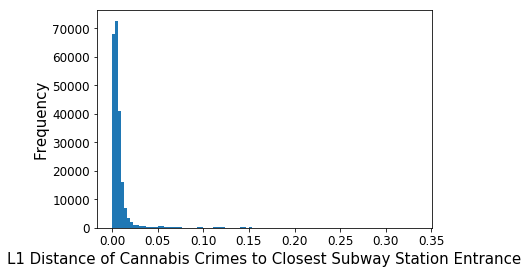

In [91]:
nyc_cann['closest_subway_distance_l1'].hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("L1 Distance of Cannabis Crimes to Closest Subway Station Entrance", fontsize=15)
plt.ylabel("Frequency", fontsize=15)

(0, 0.03)

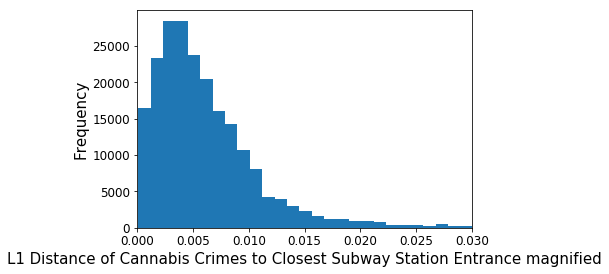

In [114]:
nyc_cann['closest_subway_distance_l1'].hist(bins=300, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("L1 Distance of Cannabis Crimes to Closest Subway Station Entrance magnified", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlim([0, 0.03])

Text(0, 0.5, 'Frequency')

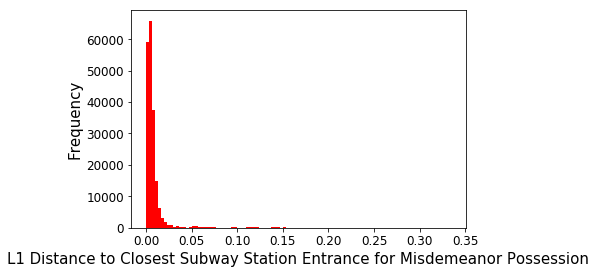

In [93]:
nyc_cann_mp['closest_subway_distance_l1'].hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12, color='r')
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Misdemeanor Possession", fontsize=15)
plt.ylabel("Frequency", fontsize=15)

(0, 0.03)

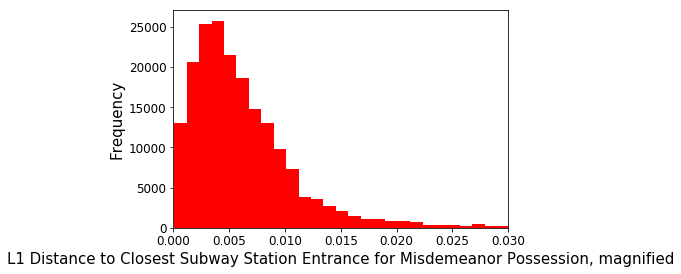

In [115]:
nyc_cann_mp['closest_subway_distance_l1'].hist(bins=300, grid=False, xlabelsize=12, ylabelsize=12, color='r')
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Misdemeanor Possession, magnified", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlim([0, 0.03])

Text(0, 0.5, 'Frequency')

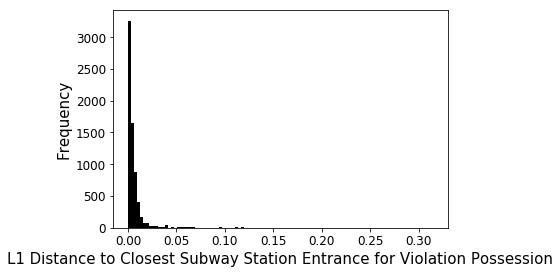

In [95]:
nyc_cann_vp['closest_subway_distance_l1'].hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12, color='k')
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Violation Possession", fontsize=15)
plt.ylabel("Frequency", fontsize=15)

(0, 0.03)

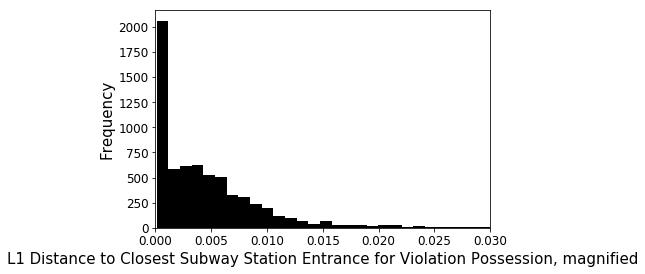

In [116]:
nyc_cann_vp['closest_subway_distance_l1'].hist(bins=300, grid=False, xlabelsize=12, ylabelsize=12, color='k')
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Violation Possession, magnified", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlim([0, 0.03])

Text(0, 0.5, 'Frequency')

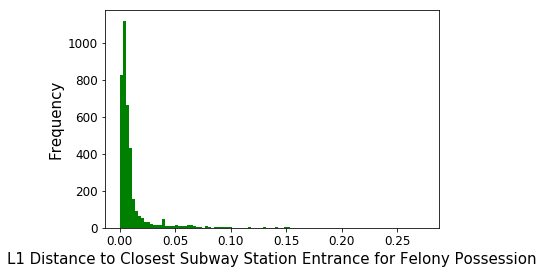

In [97]:
nyc_cann_fp['closest_subway_distance_l1'].hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12, color='g')
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Felony Possession", fontsize=15)
plt.ylabel("Frequency", fontsize=15)

(0, 0.03)

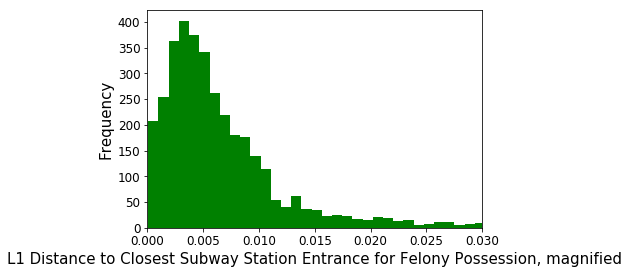

In [117]:
nyc_cann_fp['closest_subway_distance_l1'].hist(bins=300, grid=False, xlabelsize=12, ylabelsize=12, color='g')
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Felony Possession, magnified", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlim([0, 0.03])

Text(0, 0.5, 'Frequency')

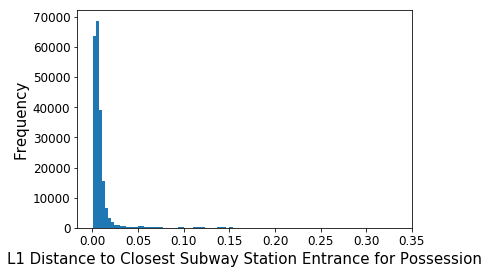

In [99]:
nyc_cann_p['closest_subway_distance_l1'].hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Possession", fontsize=15)
plt.ylabel("Frequency", fontsize=15)

(0, 0.03)

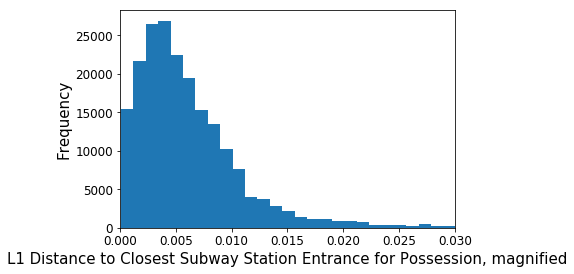

In [118]:
nyc_cann_p['closest_subway_distance_l1'].hist(bins=300, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Possession, magnified", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlim([0, 0.03])

Text(0, 0.5, 'Frequency')

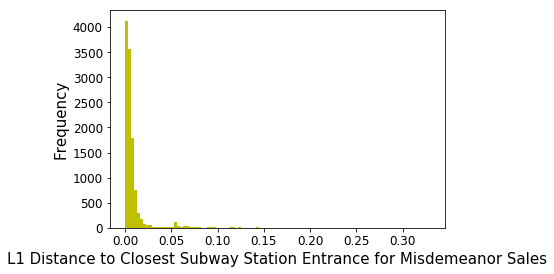

In [101]:
nyc_cann_ms['closest_subway_distance_l1'].hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12, color='y')
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Misdemeanor Sales", fontsize=15)
plt.ylabel("Frequency", fontsize=15)

(0, 0.03)

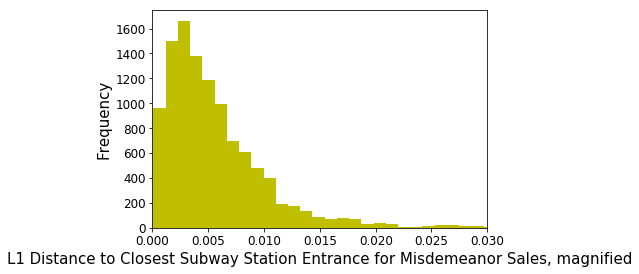

In [119]:
nyc_cann_ms['closest_subway_distance_l1'].hist(bins=300, grid=False, xlabelsize=12, ylabelsize=12, color='y')
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Misdemeanor Sales, magnified", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlim([0, 0.03])

Text(0, 0.5, 'Frequency')

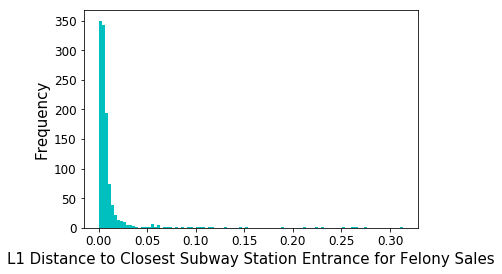

In [103]:
nyc_cann_fs['closest_subway_distance_l1'].hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12, color='c')
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Felony Sales", fontsize=15)
plt.ylabel("Frequency", fontsize=15)

(0, 0.03)

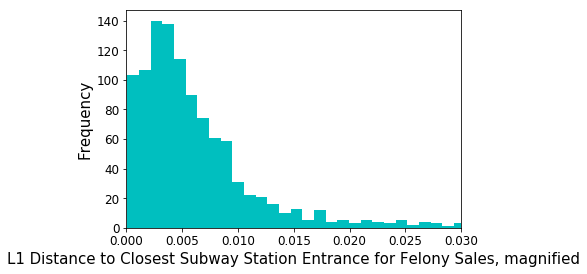

In [120]:
nyc_cann_fs['closest_subway_distance_l1'].hist(bins=300, grid=False, xlabelsize=12, ylabelsize=12, color='c')
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Felony Sales, magnified", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlim([0, 0.03])

Text(0, 0.5, 'Frequency')

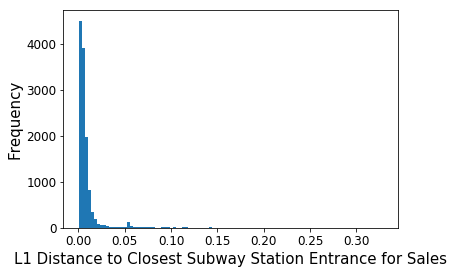

In [105]:
nyc_cann_s['closest_subway_distance_l1'].hist(bins=100, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Sales", fontsize=15)
plt.ylabel("Frequency", fontsize=15)

(0, 0.03)

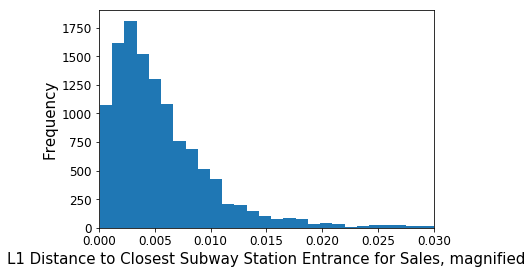

In [121]:
nyc_cann_s['closest_subway_distance_l1'].hist(bins=300, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("L1 Distance to Closest Subway Station Entrance for Sales, magnified", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlim([0, 0.03])

As can be seen above, the shape of these histograms are generally very similar, with the exception of violation possession crimes. The majority of these crimes are within 0.001 latitude/longitude units, with a steep drop-off. This suggests a higher proportion of low-level possession charges brought against people very close to subway entrances.

# Premises Type

An intriguing part of the NYPD dataset is a feature that describes the premises type that the arrest occurred in. As can be seen below, the majority of cannabis arrests happen either on the street or in the New York City housing projects. Violation possession arrests also frequently occur in the New York City subway system, and felony possession arrests frequently occur in residences.

In [114]:
round(nyc_cann['PREM_TYP_DESC'].value_counts(normalize=True).head(10), 3)*100

STREET                         57.9
RESIDENCE - PUBLIC HOUSING     19.1
RESIDENCE - APT. HOUSE          7.8
PARK/PLAYGROUND                 5.9
OTHER                           2.4
TRANSIT - NYC SUBWAY            1.6
PUBLIC BUILDING                 1.0
RESIDENCE-HOUSE                 1.0
unknown                         0.8
PARKING LOT/GARAGE (PUBLIC)     0.5
Name: PREM_TYP_DESC, dtype: float64

In [115]:
round(nyc_cann_mp['PREM_TYP_DESC'].value_counts(normalize=True).head(10), 3)*100

STREET                         57.9
RESIDENCE - PUBLIC HOUSING     20.2
RESIDENCE - APT. HOUSE          7.8
PARK/PLAYGROUND                 6.2
OTHER                           2.4
PUBLIC BUILDING                 1.1
RESIDENCE-HOUSE                 0.9
unknown                         0.8
TRANSIT - NYC SUBWAY            0.6
PARKING LOT/GARAGE (PUBLIC)     0.5
Name: PREM_TYP_DESC, dtype: float64

In [116]:
round(nyc_cann_vp['PREM_TYP_DESC'].value_counts(normalize=True).head(10), 3)*100

STREET                        36.4
TRANSIT - NYC SUBWAY          32.0
RESIDENCE - PUBLIC HOUSING    11.3
RESIDENCE - APT. HOUSE         5.6
PARK/PLAYGROUND                3.0
OTHER                          2.9
PUBLIC SCHOOL                  1.8
PUBLIC BUILDING                1.1
RESIDENCE-HOUSE                1.0
unknown                        0.7
Name: PREM_TYP_DESC, dtype: float64

In [117]:
round(nyc_cann_fp['PREM_TYP_DESC'].value_counts(normalize=True).head(10), 3)*100

STREET                        61.0
RESIDENCE - APT. HOUSE        15.0
RESIDENCE - PUBLIC HOUSING     7.2
RESIDENCE-HOUSE                6.6
OTHER                          1.9
unknown                        0.9
TAXI (LIVERY LICENSED)         0.9
AIRPORT TERMINAL               0.8
PUBLIC BUILDING                0.6
COMMERCIAL BUILDING            0.5
Name: PREM_TYP_DESC, dtype: float64

In [118]:
round(nyc_cann_p['PREM_TYP_DESC'].value_counts(normalize=True).head(10), 3)*100

STREET                         57.2
RESIDENCE - PUBLIC HOUSING     19.6
RESIDENCE - APT. HOUSE          7.8
PARK/PLAYGROUND                 6.0
OTHER                           2.4
TRANSIT - NYC SUBWAY            1.6
PUBLIC BUILDING                 1.0
RESIDENCE-HOUSE                 1.0
unknown                         0.8
PARKING LOT/GARAGE (PUBLIC)     0.5
Name: PREM_TYP_DESC, dtype: float64

In [119]:
round(nyc_cann_ms['PREM_TYP_DESC'].value_counts(normalize=True).head(10), 3)*100

STREET                        68.6
RESIDENCE - PUBLIC HOUSING    10.3
RESIDENCE - APT. HOUSE         7.4
PARK/PLAYGROUND                4.3
OTHER                          2.0
GROCERY/BODEGA                 1.5
RESIDENCE-HOUSE                1.1
PUBLIC BUILDING                1.0
unknown                        0.8
TRANSIT - NYC SUBWAY           0.5
Name: PREM_TYP_DESC, dtype: float64

In [120]:
round(nyc_cann_fs['PREM_TYP_DESC'].value_counts(normalize=True).head(10), 3)*100

STREET                        62.3
RESIDENCE - PUBLIC HOUSING    11.9
RESIDENCE - APT. HOUSE        10.0
RESIDENCE-HOUSE                3.4
OTHER                          2.2
PARK/PLAYGROUND                1.9
PUBLIC SCHOOL                  1.3
unknown                        1.2
PUBLIC BUILDING                0.9
GROCERY/BODEGA                 0.7
Name: PREM_TYP_DESC, dtype: float64

# Jurisdictions Responsible for Cannabis Arrests 

As can be expected, the jurisdiction responsible for the majority of cannabis arrests are the NYPD, the New York City Housing Authority (NYCHA), and to a much lesser degree the N.Y. Transit Police. The fact that 19% of cannabis arrests fall under the jurisdiction of the NYCHA shows how heavily policed these public housing projects are.

In [121]:
round(nyc_cann['JURIS_DESC'].value_counts(normalize=True).head(6), 3)*100

N.Y. POLICE DEPT       78.5
N.Y. HOUSING POLICE    19.4
N.Y. TRANSIT POLICE     1.6
OTHER                   0.2
PORT AUTHORITY          0.1
POLICE DEPT NYC         0.1
Name: JURIS_DESC, dtype: float64

In [122]:
round(nyc_cann_mp['JURIS_DESC'].value_counts(normalize=True).head(6), 3)*100

N.Y. POLICE DEPT       78.5
N.Y. HOUSING POLICE    20.5
N.Y. TRANSIT POLICE     0.6
OTHER                   0.1
PORT AUTHORITY          0.1
POLICE DEPT NYC         0.1
Name: JURIS_DESC, dtype: float64

The fact that the N.Y. Transit Police takes the NYCHA's place for violation possession charges show an interesting difference in enforcement of the different cannabis types, and reflects the fact that the premises type for violation possession is frequently in the NYC subway system.

In [123]:
round(nyc_cann_vp['JURIS_DESC'].value_counts(normalize=True).head(8), 3)*100

N.Y. POLICE DEPT       53.9
N.Y. TRANSIT POLICE    32.7
N.Y. HOUSING POLICE    11.5
PORT AUTHORITY          0.8
OTHER                   0.6
TRI-BORO BRDG TUNNL     0.2
HEALTH & HOSP CORP      0.1
POLICE DEPT NYC         0.1
Name: JURIS_DESC, dtype: float64

In [124]:
round(nyc_cann_fp['JURIS_DESC'].value_counts(normalize=True).head(7), 3)*100

N.Y. POLICE DEPT       90.1
N.Y. HOUSING POLICE     7.4
PORT AUTHORITY          1.1
N.Y. TRANSIT POLICE     0.5
OTHER                   0.3
N.Y. STATE POLICE       0.3
TRI-BORO BRDG TUNNL     0.2
Name: JURIS_DESC, dtype: float64

In [125]:
round(nyc_cann_p['JURIS_DESC'].value_counts(normalize=True).head(6), 3)*100

N.Y. POLICE DEPT       77.9
N.Y. HOUSING POLICE    20.0
N.Y. TRANSIT POLICE     1.7
OTHER                   0.2
PORT AUTHORITY          0.1
POLICE DEPT NYC         0.1
Name: JURIS_DESC, dtype: float64

In [126]:
round(nyc_cann_ms['JURIS_DESC'].value_counts(normalize=True).head(6), 3)*100

N.Y. POLICE DEPT       88.5
N.Y. HOUSING POLICE    10.5
N.Y. TRANSIT POLICE     0.5
OTHER                   0.2
PORT AUTHORITY          0.2
POLICE DEPT NYC         0.1
Name: JURIS_DESC, dtype: float64

In [127]:
round(nyc_cann_fs['JURIS_DESC'].value_counts(normalize=True), 3)*100

N.Y. POLICE DEPT       85.9
N.Y. HOUSING POLICE    12.6
N.Y. TRANSIT POLICE     0.7
N.Y. STATE POLICE       0.3
OTHER                   0.2
POLICE DEPT NYC         0.2
PORT AUTHORITY          0.2
Name: JURIS_DESC, dtype: float64

In [128]:
round(nyc_cann_s['JURIS_DESC'].value_counts(normalize=True).head(6), 3)*100

N.Y. POLICE DEPT       88.3
N.Y. HOUSING POLICE    10.7
N.Y. TRANSIT POLICE     0.5
OTHER                   0.2
PORT AUTHORITY          0.2
POLICE DEPT NYC         0.1
Name: JURIS_DESC, dtype: float64

# Housing Developments

Because of the fact that nearly 20% of all cannabis arrests occur in N.Y. housing projects, it pays to look at the 'HADEVELOPT' feature, which tells which housing project the cannabis arrest occurred in. Because there are so many unknown values in this feature (as roughly 80% of cannabis arrests occurred outside of N.Y. housing projects), it makes sense for reporting purposes to first re-base the feature by removing the unknown values. The feature is called 'nyc_cann_hr'; 'hr' is short for 'housing development reported'.

In [129]:
nyc_cann['HADEVELOPT'].value_counts().head(10)

not_housing_devpt_crime    193179
CASTLE HILL                   851
BUTLER                        814
BRONXDALE                     655
SOUNDVIEW                     616
LINDEN                        574
MARCY                         528
THROGGS NECK                  436
WHITMAN                       419
MONROE                        419
Name: HADEVELOPT, dtype: int64

In [130]:
nyc_cann_hr = nyc_cann[nyc_cann.HADEVELOPT != 'not_housing_devpt_crime']

The top 10 N.Y. housing developments with the highest proportion of cannabis arrests are all in the South Bronx or in economically disadvantaged areas of Brooklyn.

In [131]:
round(nyc_cann_hr['HADEVELOPT'].value_counts(normalize=True).head(10), 3)*100

CASTLE HILL     3.1
BUTLER          3.0
BRONXDALE       2.4
SOUNDVIEW       2.3
LINDEN          2.1
MARCY           1.9
THROGGS NECK    1.6
WHITMAN         1.5
MONROE          1.5
LINCOLN         1.5
Name: HADEVELOPT, dtype: float64

In [132]:
nyc_cann_hr_mp = nyc_cann_hr[nyc_cann_hr.misd_poss == 1]

In [133]:
round(nyc_cann_hr_mp['HADEVELOPT'].value_counts(normalize=True).head(10), 3)*100

CASTLE HILL     3.1
BUTLER          3.1
BRONXDALE       2.4
SOUNDVIEW       2.2
LINDEN          2.2
MARCY           1.9
THROGGS NECK    1.6
MONROE          1.6
WHITMAN         1.5
LINCOLN         1.5
Name: HADEVELOPT, dtype: float64

In [134]:
nyc_cann_hr_vp = nyc_cann_hr[nyc_cann_hr.viol_poss == 1]

When looking at violation possession charges, Pink House, Hammel House, and Farragut House suddenly jump into the top 10. Pink House is in East New York, Hammel House is in Rockaway Beach, and Farragut is in Vinegar Hill, Brooklyn.

In [135]:
round(nyc_cann_hr_vp['HADEVELOPT'].value_counts(normalize=True).head(10), 3)*100

BRONXDALE        4.1
PINK             3.8
SOUNDVIEW        3.4
HAMMEL           3.3
MARCY            3.3
CYPRESS HILLS    2.9
FARRAGUT         2.6
THROGGS NECK     2.5
MONROE           2.5
VAN DYKE I       2.1
Name: HADEVELOPT, dtype: float64

In [136]:
nyc_cann_hr_fp = nyc_cann_hr[nyc_cann_hr.felony_poss == 1]

For felony possession levels, Red Hook West, jumps to the top position.

In [137]:
round(nyc_cann_hr_fp['HADEVELOPT'].value_counts(normalize=True).head(10), 3)*100

RED HOOK WEST    4.7
FARRAGUT         3.1
VAN DYKE I       2.6
MARCY            2.6
BUTLER           2.6
BUSHWICK         2.6
ARMSTRONG I      2.6
TOMPKINS         2.1
POMONOK          2.1
RED HOOK EAST    1.6
Name: HADEVELOPT, dtype: float64

In [138]:
nyc_cann_hr_p = nyc_cann_hr[nyc_cann_hr.possession == 1]

In [139]:
round(nyc_cann_hr_p['HADEVELOPT'].value_counts(normalize=True).head(10), 3)*100

CASTLE HILL     3.1
BUTLER          3.0
BRONXDALE       2.4
SOUNDVIEW       2.2
LINDEN          2.2
MARCY           2.0
THROGGS NECK    1.6
MONROE          1.6
WHITMAN         1.6
LINCOLN         1.5
Name: HADEVELOPT, dtype: float64

In [140]:
nyc_cann_hr_ms = nyc_cann_hr[nyc_cann_hr.misd_sales == 1]

In [141]:
round(nyc_cann_hr_ms['HADEVELOPT'].value_counts(normalize=True).head(10), 3)*100

ARMSTRONG I     4.7
CASTLE HILL     4.7
SOUNDVIEW       3.0
GRANT           2.4
THROGGS NECK    2.1
WALD            2.1
BUTLER          2.1
BRONXDALE       1.8
POMONOK         1.8
CLINTON         1.7
Name: HADEVELOPT, dtype: float64

In [142]:
nyc_cann_hr_fs = nyc_cann_hr[nyc_cann_hr.felony_sales == 1]

Red Hook West is also #1 for felony sales.

In [143]:
round(nyc_cann_hr_fs['HADEVELOPT'].value_counts(normalize=True).head(10), 3)*100

RED HOOK WEST        4.2
SAINT MARY'S PARK    3.2
MORRIS II            3.2
WILLIAMSBURG         3.2
SOUNDVIEW            3.2
JACKSON              3.2
MARCY                3.2
CASTLE HILL          3.2
BUTLER               2.1
BUSHWICK             2.1
Name: HADEVELOPT, dtype: float64

In [144]:
nyc_cann_hr_s = nyc_cann_hr[nyc_cann_hr.sales == 1]

In [145]:
round(nyc_cann_hr_s['HADEVELOPT'].value_counts(normalize=True).head(10), 3)*100

CASTLE HILL     4.5
ARMSTRONG I     4.4
SOUNDVIEW       3.0
GRANT           2.2
BUTLER          2.1
WALD            2.0
THROGGS NECK    2.0
POMONOK         1.7
MORRIS II       1.6
BRONXDALE       1.6
Name: HADEVELOPT, dtype: float64

# Daily Time Windows of Cannabis Arrests

Cannabis arrests occur more frequently during certain times of the day. 39% occur during the daytime (6 am - 6 pm), and 61% occur during the nighttime (6 pm - 6 am).

In [189]:
round(nyc_cann['day_tw'].value_counts(normalize=True), 3)*100

0    61.1
1    38.9
Name: day_tw, dtype: float64

The work day (9 am - 6 pm) composes most of the daytime arrests, and 37.5% of the total. Early morning (6 am - 7:30 am) and the morning rush hour (7:30 am - 9 am) have very little arrests (0.6% and 0.9 respectively), but this picks up during the lunch hour (12-1 pm), when 3.9% of the arrests are made.

In [190]:
round(nyc_cann['early_morn'].value_counts(normalize=True), 3)*100

0    99.4
1     0.6
Name: early_morn, dtype: float64

In [191]:
round(nyc_cann['morn_rush_hr'].value_counts(normalize=True), 3)*100

0    99.1
1     0.9
Name: morn_rush_hr, dtype: float64

In [192]:
round(nyc_cann['work_day'].value_counts(normalize=True), 3)*100

0    62.5
1    37.5
Name: work_day, dtype: float64

In [193]:
round(nyc_cann['lunch_hr'].value_counts(normalize=True), 3)*100

0    96.1
1     3.9
Name: lunch_hr, dtype: float64

The long New York metropolitan area's evening rush hour (4:30 pm - 7 pm) straddles the daytime (6 am - 6 pm) and nighttime (6 pm - 6 am) windows, but one sees a fairly high concentration of arrests happening during this time window.

In [194]:
round(nyc_cann['eve_rush_hr'].value_counts(normalize=True), 3)*100

0    81.9
1    18.1
Name: eve_rush_hr, dtype: float64

The nighttime sees the majority of cannabis arrests, at 61%.

In [195]:
round(nyc_cann['night_tw'].value_counts(normalize=True), 3)*100

1    61.1
0    38.9
Name: night_tw, dtype: float64

Overlapping with the evening rush hour, the dinner window of 6-8 pm has a high concentration of arrests for just a two hour window, and has nearly as many arrests that occur in the 2.5 hour window of the evening rush hour.

In [196]:
round(nyc_cann['dinner'].value_counts(normalize=True), 3)*100

0    82.6
1    17.4
Name: dinner, dtype: float64

Evening (8-10 pm) has a similarly high concentration of arrests at 19% for a two hour window.

In [197]:
round(nyc_cann['evening'].value_counts(normalize=True), 3)*100

0    81.0
1    19.0
Name: evening, dtype: float64

Late night (10 pm - 6 am) has 26% of the arrests for an 8 hour window, showing that more than half of the nighttime arrests do not happen during the nightlife hours, but after work and before the working population would typically go to bed.

In [198]:
round(nyc_cann['late_night'].value_counts(normalize=True), 3)*100

0    73.8
1    26.2
Name: late_night, dtype: float64

To easily visualize the number of arrests made per hour (across all years), the hour of the day is extracted and then displayed in the following line plot. 

In [199]:
hour = nyc_cann['start_hour'].value_counts().sort_index()
hour

0     11301
1      8345
2      4166
3      2194
4      1030
5       530
6       909
7       681
8      1438
9      2461
10     3161
11     5092
12     7676
13    10352
14    11760
15    12093
16    14048
17    14540
18    16193
19    20262
20    20431
21    19675
22    17904
23    14062
Name: start_hour, dtype: int64

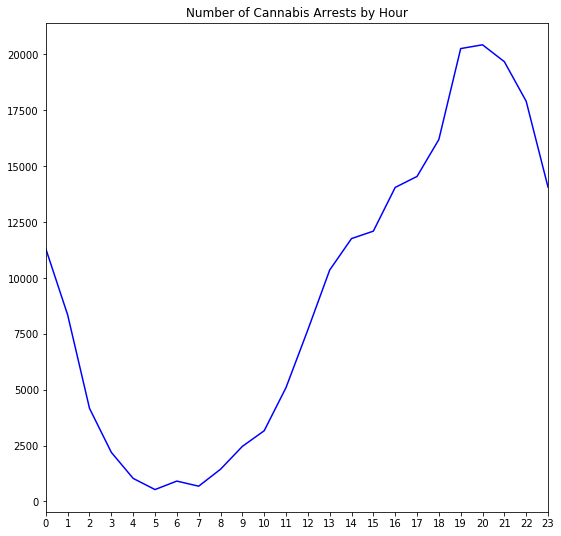

In [200]:
hour.plot(xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], figsize=(9, 9), c='blue', title='Number of Cannabis Arrests by Hour')

It has been well reported that during Mayor Bloomberg's time as mayor, cannabis arrests reached their peak. One can see that 2006 has 15,127 arrests, and that this increases to 24,468 arrests in 2010. This holds fairly steady for 2011 (23,827), drops a bit in 2012 (20,611) as criticism of Bloomberg's "stop and frisk" program mounts, and then drops significantly in 2013 (16,206) when the "stop and frisk" program is judged as unconstitutional by Judge Scheindlin (Goldstein, NY Times, 2013). Mayor DeBlasio, who vowed to reverse the program, took office in 2014, but cannabis arrests remained fairly consistent in that year compared to 2013 (15,787). By 2015, the number was still fairly high but dropped significantly (11,424). This number stayed consistent through 2017, and then dropped by half in 2018 as discussions of cannabis legalization in New York intensified.

In [201]:
year = nyc_cann['start_year'].value_counts().sort_index()
year

2006    15127
2007    19686
2008    20571
2009    23612
2010    24467
2011    23827
2012    20611
2013    16206
2014    15787
2015    11424
2016    11789
2017    11458
2018     5739
Name: start_year, dtype: int64

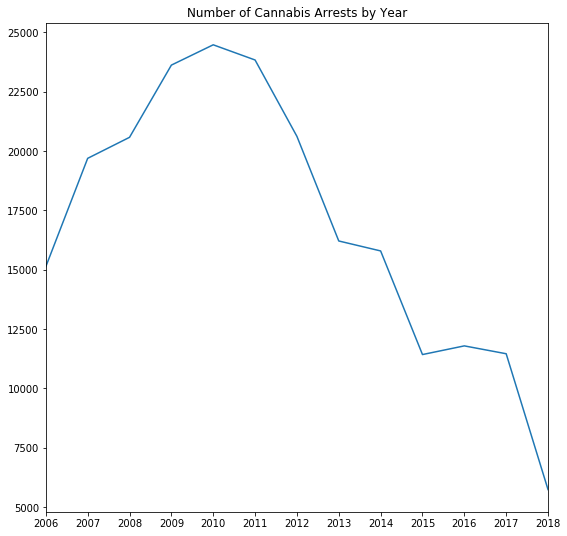

In [202]:
year.plot(xticks=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], figsize=(9, 9), title='Number of Cannabis Arrests by Year')

Each month of the year has about the same amount of cannabis arrests, but August has the highest number and the number drops in November and December during the Holiday season.

In [203]:
month = nyc_cann['start_month'].value_counts().sort_index()
month

1     18328
2     17732
3     19767
4     18936
5     19534
6     18157
7     18844
8     20707
9     19374
10    19425
11    15925
12    13575
Name: start_month, dtype: int64

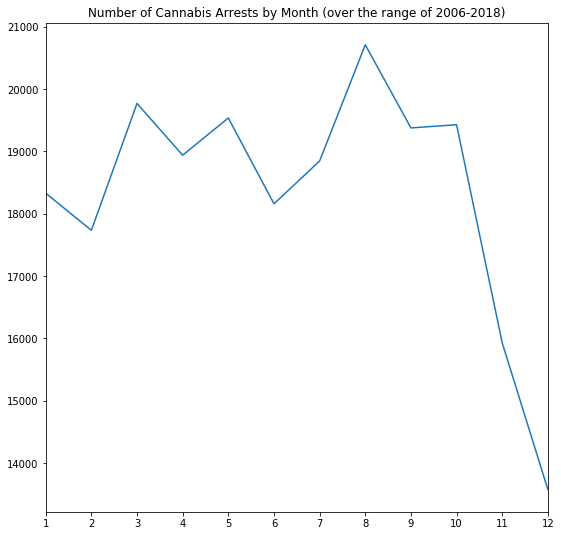

In [204]:
month.plot(xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], figsize=(9, 9), title='Number of Cannabis Arrests by Month (over the range of 2006-2018)')

Each day of the month has a fairly consistent number of cannabis arrests, ranging from 5,660 to 7,900 arrests a day. The number drops somewhat in the last 10 days of the month. The 31st has roughly half the arrests as the rest of the month, because not every month has 31 days.

In [205]:
day = nyc_cann['start_day'].value_counts().sort_index()
day

1     7231
2     7524
3     7607
4     7258
5     7605
6     7427
7     7329
8     7887
9     7685
10    7774
11    7852
12    7900
13    7687
14    7434
15    7519
16    7560
17    7350
18    7251
19    7253
20    7750
21    7344
22    6955
23    6925
24    6688
25    6559
26    6498
27    6752
28    6654
29    6004
30    5660
31    3382
Name: start_day, dtype: int64

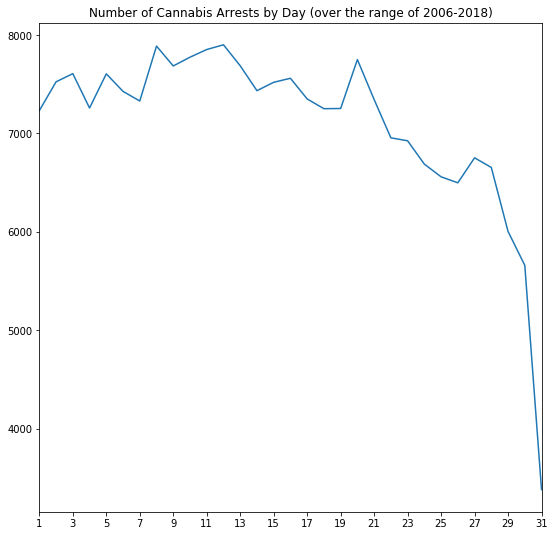

In [206]:
day.plot(xticks=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31], figsize=(9, 9), title='Number of Cannabis Arrests by Day (over the range of 2006-2018)')

Because of the importance of holidays to various cultural groups, and because of the differences in how certain groups of people are arrested for cannabis, it makes sense to look at whether certain holidays have higher concentrations of cannabis arrests. Due to the cultural diversity of New York City, certain holidays are included that would not be typically celebrated in other parts of the United States. Intriguingly, the holidays with the highest number of cannabis arrests are Hindu, Jewish, and Muslim holidays. Diwali had 656 arrests, Yom Kippur has 707, Rosh Hashanah has 677, Eid al-Fitr has 644, and Eid al-Adha has 544. Inexplicably, Valentine's Day has 531 arrests. St. Patrick's Day also has a high number at 542, which may be due to co-occurring cannabis use that happens during the large amount of public drunkenness that occurs on New York City streets on that day. April 20th has the highest number of arrests because of its cultural connection to cannabis.

In [207]:
nyc_cann['new_years_day'].value_counts()

0    219924
1       380
Name: new_years_day, dtype: int64

In [231]:
nyc_cann['mlk'].value_counts()

0    219901
1       403
Name: mlk, dtype: int64

In [208]:
nyc_cann['valentines'].value_counts()

0    219773
1       531
Name: valentines, dtype: int64

In [232]:
nyc_cann['pres'].value_counts()

0    219899
1       405
Name: pres, dtype: int64

In [209]:
nyc_cann['st_patricks'].value_counts()

0    219762
1       542
Name: st_patricks, dtype: int64

In [233]:
nyc_cann['easter'].value_counts()

0    220041
1       263
Name: easter, dtype: int64

In [230]:
nyc_cann['four_twenty'].value_counts()

0    219567
1       737
Name: four_twenty, dtype: int64

In [241]:
nyc_cann['memorial_day'].value_counts()

0    220079
1       225
Name: memorial_day, dtype: int64

In [235]:
nyc_cann['pr_parade'].value_counts()

0    219868
1       436
Name: pr_parade, dtype: int64

In [210]:
nyc_cann['july_4th'].value_counts()

0    219779
1       525
Name: july_4th, dtype: int64

In [238]:
nyc_cann['eid_al_fitr'].value_counts()

0    219640
1       664
Name: eid_al_fitr, dtype: int64

In [239]:
nyc_cann['eid_al_adha'].value_counts()

0    219760
1       544
Name: eid_al_adha, dtype: int64

In [242]:
nyc_cann['labor_day'].value_counts()

0    219913
1       391
Name: labor_day, dtype: int64

In [236]:
nyc_cann['yomkippur'].value_counts()

0    219597
1       707
Name: yomkippur, dtype: int64

In [237]:
nyc_cann['rosh_hashanah'].value_counts()

0    219627
1       677
Name: rosh_hashanah, dtype: int64

In [234]:
nyc_cann['diwali'].value_counts()

0    219648
1       656
Name: diwali, dtype: int64

In [211]:
nyc_cann['halloween'].value_counts()

0    219854
1       450
Name: halloween, dtype: int64

In [240]:
nyc_cann['hanukkah'].value_counts()

0    219873
1       431
Name: hanukkah, dtype: int64

In [243]:
nyc_cann['thanksgiving'].value_counts()

0    220189
1       115
Name: thanksgiving, dtype: int64

In [212]:
nyc_cann['christmas_eve'].value_counts()

0    220203
1       101
Name: christmas_eve, dtype: int64

In [213]:
nyc_cann['christmas'].value_counts()

0    220245
1        59
Name: christmas, dtype: int64

In [124]:
nyc_cann['new_years_eve'].value_counts()

0    220126
1       178
Name: new_years_eve, dtype: int64

# Covariance Matrices and Correlations

The next section looks at covariance matrices and correlations. Because the current loaded DataFrame largely has a categorical data structure, covariance matrices and correlations won't be able to be run on it. So the concatenated machine learning version of the DataFrames with binarized features for all cannabis crimes and the sample of non-cannabis crimes is loaded.

In [122]:
nyc = pd.read_csv("concat_cann_non_cann_for_ml.csv", index_col=0)

The following cells look at the covariance matrices and correlation coefficients of different features and the cannabis crime flag. First, a heatmap of several features of interest is displayed. Intriguingly, there is not really any clear and strong correlations between racial/ethnic groups and boroughs that have the highest concentration of cannabis arrests. This hints at multi-componential interactions between the overall feature set and cannabis crime, which will be more fully explored when building classification machine learning models.

In [127]:
df_for_heatmap = nyc[['cannabis_crime', 'SUSP_RACE_cleaned_BLACK', 'SUSP_RACE_cleaned_BLACK HISPANIC', 
                     'SUSP_RACE_cleaned_WHITE', 'SUSP_RACE_cleaned_WHITE HISPANIC', 'BORO_NM_BRONX', 
                     'BORO_NM_BROOKLYN', 'SUSP_AGE_GROUP_cleaned_18-24']]

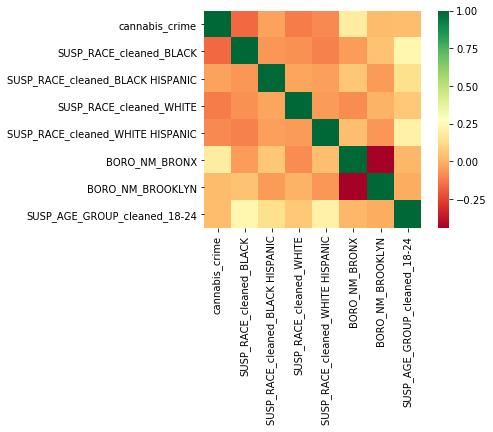

In [128]:
sns.heatmap(df_for_heatmap.corr(), square=True, cmap='RdYlGn')

A simple Pearson's R function is defined to look at correlations between the 'cannabis_crime' feature and various other features in the DataFrame.

In [130]:
def pearson_r(x, y):
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

The Pearson's R and covariance matrix is run repeatedly to try and identify strong correlations between the 'cannabis_crime' feature and the rest of the feature set. Intriguingly, there are not really any strong correlations. The only thing that stands out in the cells below is the 0.59 covariance between the hour of the day and the 'cannabis_crime' feature. The lack of strong correlations and covariance does point to the need of developing a series of strong machine learning models that can help provide a gestalt picture of the many features that differentiate cannabis crimes from all other crimes, cannabis possession from cannabis sales crimes, and the five legal levels of cannabis crime in New York City between 2006 and 2018.

In [131]:
r_black = pearson_r(nyc['SUSP_RACE_cleaned_BLACK'], nyc['cannabis_crime'])
r_black

-0.1606893247865442

In [132]:
cov_matrix_black_hisp = np.cov(nyc['SUSP_RACE_cleaned_BLACK HISPANIC'], nyc['cannabis_crime'])
cov_matrix_black_hisp

array([[ 0.0216454 , -0.00227527],
       [-0.00227527,  0.25000057]])

In [133]:
r_black_hisp = pearson_r(nyc['SUSP_RACE_cleaned_BLACK HISPANIC'], nyc['cannabis_crime'])
r_black_hisp

-0.030929984063508966

In [134]:
cov_matrix_white_hisp = np.cov(nyc['SUSP_RACE_cleaned_WHITE HISPANIC'], nyc['cannabis_crime'])
cov_matrix_white_hisp

array([[ 0.06096362, -0.01112216],
       [-0.01112216,  0.25000057]])

In [135]:
r_white_hisp = pearson_r(nyc['SUSP_RACE_cleaned_WHITE HISPANIC'], nyc['cannabis_crime'])
r_white_hisp

-0.09009135666873107

In [136]:
cov_matrix_white = np.cov(nyc['SUSP_RACE_cleaned_WHITE'], nyc['cannabis_crime'])
cov_matrix_white

array([[ 0.03344509, -0.01099279],
       [-0.01099279,  0.25000057]])

In [137]:
r_white = pearson_r(nyc['SUSP_RACE_cleaned_WHITE'], nyc['cannabis_crime'])
r_white

-0.12021848494858922

In [138]:
cov_matrix_less_18 = np.cov(nyc['SUSP_AGE_GROUP_cleaned_<18'], nyc['cannabis_crime'])
cov_matrix_less_18

array([[ 0.01176454, -0.00099181],
       [-0.00099181,  0.25000057]])

In [139]:
r_less_18 = pearson_r(nyc['SUSP_AGE_GROUP_cleaned_<18'], nyc['cannabis_crime'])
r_less_18

-0.018288244940485327

In [140]:
cov_matrix_18_24 = np.cov(nyc['SUSP_AGE_GROUP_cleaned_18-24'], nyc['cannabis_crime'])
cov_matrix_18_24

array([[0.05377795, 0.0036427 ],
       [0.0036427 , 0.25000057]])

In [141]:
r_18_24 = pearson_r(nyc['SUSP_AGE_GROUP_cleaned_18-24'], nyc['cannabis_crime'])
r_18_24

0.03141600875094162

In [142]:
cov_matrix_25_44 = np.cov(nyc['SUSP_AGE_GROUP_cleaned_25-44'], nyc['cannabis_crime'])
cov_matrix_25_44

array([[ 0.08754368, -0.01337133],
       [-0.01337133,  0.25000057]])

In [143]:
r_25_44 = pearson_r(nyc['SUSP_AGE_GROUP_cleaned_25-44'], nyc['cannabis_crime'])
r_25_44

-0.09038400864660147

In [144]:
cov_matrix_45_64 = np.cov(nyc['SUSP_AGE_GROUP_cleaned_45-64'], nyc['cannabis_crime'])
cov_matrix_45_64

array([[ 0.02777057, -0.00781195],
       [-0.00781195,  0.25000057]])

In [145]:
r_45_64 = pearson_r(nyc['SUSP_AGE_GROUP_cleaned_45-64'], nyc['cannabis_crime'])
r_45_64

-0.09375545871286593

In [146]:
cov_matrix_65plus = np.cov(nyc['SUSP_AGE_GROUP_cleaned_65+'], nyc['cannabis_crime'])
cov_matrix_65plus

array([[ 0.00194578, -0.00077734],
       [-0.00077734,  0.25000057]])

In [147]:
r_65_plus = pearson_r(nyc['SUSP_AGE_GROUP_cleaned_65+'], nyc['cannabis_crime'])
r_65_plus

-0.035244516679375164

In [148]:
cov_matrix_male = np.cov(nyc['SUSP_SEX_cleaned_M'], nyc['cannabis_crime'])
cov_matrix_male

array([[ 0.1755519 , -0.04207718],
       [-0.04207718,  0.25000057]])

In [149]:
r_male = pearson_r(nyc['SUSP_SEX_cleaned_M'], nyc['cannabis_crime'])
r_male

-0.2008507023261888

In [150]:
cov_matrix_female = np.cov(nyc['SUSP_SEX_cleaned_F'], nyc['cannabis_crime'])
cov_matrix_female

array([[ 0.05531314, -0.02112427],
       [-0.02112427,  0.25000057]])

In [151]:
r_female = pearson_r(nyc['SUSP_SEX_cleaned_F'], nyc['cannabis_crime'])
r_female

-0.1796374919686976

In [152]:
cov_matrix_long = np.cov(nyc['Longitude'], nyc['cannabis_crime'])
cov_matrix_long

array([[0.00452147, 0.00085046],
       [0.00085046, 0.25000057]])

In [153]:
r_long_cann = pearson_r(nyc['Longitude'], nyc['cannabis_crime'])
r_long_cann

0.025295395092470013

In [154]:
cov_matrix_lat = np.cov(nyc['Latitude'], nyc['cannabis_crime'])
cov_matrix_lat

array([[0.00745028, 0.00695219],
       [0.00695219, 0.25000057]])

In [155]:
r_lat = pearson_r(nyc['Latitude'], nyc['cannabis_crime'])
r_lat

0.1610885927445888

In [156]:
cov_matrix_bronx = np.cov(nyc['BORO_NM_BRONX'], nyc['cannabis_crime'])
cov_matrix_bronx

array([[0.21100506, 0.04584131],
       [0.04584131, 0.25000057]])

In [157]:
r_bronx = pearson_r(nyc['BORO_NM_BRONX'], nyc['cannabis_crime'])
r_bronx

0.19959058240985755

In [158]:
cov_matrix_brooklyn = np.cov(nyc['BORO_NM_BROOKLYN'], nyc['cannabis_crime'])
cov_matrix_brooklyn

array([[0.21406461, 0.00684397],
       [0.00684397, 0.25000057]])

In [159]:
r_brooklyn = pearson_r(nyc['BORO_NM_BROOKLYN'], nyc['cannabis_crime'])
r_brooklyn

0.029584552483929306

In [160]:
cov_matrix_manhattan = np.cov(nyc['BORO_NM_MANHATTAN'], nyc['cannabis_crime'])
cov_matrix_manhattan

array([[ 0.17525064, -0.00756229],
       [-0.00756229,  0.25000057]])

In [161]:
r_manhattan = pearson_r(nyc['BORO_NM_MANHATTAN'], nyc['cannabis_crime'])
r_manhattan

-0.03612878025228078

In [162]:
cov_matrix_queens = np.cov(nyc['BORO_NM_QUEENS'], nyc['cannabis_crime'])
cov_matrix_queens

array([[ 0.10789728, -0.03960899],
       [-0.03960899,  0.25000057]])

In [163]:
r_queens = pearson_r(nyc['BORO_NM_QUEENS'], nyc['cannabis_crime'])
r_queens

-0.2411671001865991

In [164]:
cov_matrix_staten = np.cov(nyc['BORO_NM_STATEN ISLAND'], nyc['cannabis_crime'])
cov_matrix_staten

array([[ 0.03522423, -0.00550944],
       [-0.00550944,  0.25000057]])

In [165]:
r_staten = pearson_r(nyc['BORO_NM_STATEN ISLAND'], nyc['cannabis_crime'])
r_staten

-0.05871061203282891

In [166]:
cov_matrix_se_bronx = np.cov(nyc['ADDR_PCT_CD_43.0'], nyc['cannabis_crime'])
cov_matrix_se_bronx

array([[0.04718869, 0.01242831],
       [0.01242831, 0.25000057]])

In [167]:
r_se_bronx = pearson_r(nyc['ADDR_PCT_CD_43.0'], nyc['cannabis_crime'])
r_se_bronx

0.11442543906987056

In [168]:
cov_matrix_em_bklyn = np.cov(nyc['ADDR_PCT_CD_75.0'], nyc['cannabis_crime'])
cov_matrix_em_bklyn 

array([[0.0478321 , 0.01011219],
       [0.01011219, 0.25000057]])

In [169]:
r_em_bklyn = pearson_r(nyc['ADDR_PCT_CD_43.0'], nyc['cannabis_crime'])
r_em_bklyn

0.11442543906987056

In [170]:
cov_matrix_sw_bx = np.cov(nyc['ADDR_PCT_CD_44.0'], nyc['cannabis_crime'])
cov_matrix_sw_bx 

array([[0.0387438 , 0.008006  ],
       [0.008006  , 0.25000057]])

In [171]:
r_sw_bx = pearson_r(nyc['ADDR_PCT_CD_44.0'], nyc['cannabis_crime'])
r_sw_bx

0.08134746114715541

In [172]:
cov_matrix_ne_bklyn = np.cov(nyc['ADDR_PCT_CD_73.0'], nyc['cannabis_crime'])
cov_matrix_ne_bklyn #Northeastern Brooklyn (Brownsville and Ocean Hill)

array([[0.03171799, 0.00652395],
       [0.00652395, 0.25000057]])

In [173]:
r_ne_bklyn = pearson_r(nyc['ADDR_PCT_CD_73.0'], nyc['cannabis_crime'])
r_ne_bklyn

0.07326348625031419

In [174]:
cov_matrix_cw_bklyn = np.cov(nyc['ADDR_PCT_CD_46.0'], nyc['cannabis_crime'])
cov_matrix_cw_bklyn #Central West Bronx (Fordham, University Heights, Morris Heights and Mount Hope)

array([[0.03096236, 0.00604053],
       [0.00604053, 0.25000057]])

In [175]:
r_cw_bklyn = pearson_r(nyc['ADDR_PCT_CD_46.0'], nyc['cannabis_crime'])
r_cw_bklyn

0.06865743675636199

In [176]:
cov_matrix_sm_bklyn = np.cov(nyc['ADDR_PCT_CD_40.0'], nyc['cannabis_crime'])
cov_matrix_sm_bklyn #Southernmost Bronx (Port Morris, Mott Haven, and Melrose)

array([[0.03215676, 0.00486828],
       [0.00486828, 0.25000057]])

In [177]:
r_sm_bklyn = pearson_r(nyc['ADDR_PCT_CD_40.0'], nyc['cannabis_crime'])
r_sm_bklyn

0.05429617465001291

In [178]:
cov_matrix_n_bx = np.cov(nyc['ADDR_PCT_CD_47.0'], nyc['cannabis_crime'])
cov_matrix_n_bx #Northern Bronx (Woodlawn, Wakefield, Williamsbridge, Baychester, Edenwald, Olinville, Fishbay, and Woodlawn Cemetary)

array([[0.02933417, 0.00625955],
       [0.00625955, 0.25000057]])

In [179]:
r_n_bx = pearson_r(nyc['ADDR_PCT_CD_47.0'], nyc['cannabis_crime'])
r_n_bx

0.07309463183760803

In [180]:
cov_matrix_n_bx2 = np.cov(nyc['ADDR_PCT_CD_52.0'], nyc['cannabis_crime'])
cov_matrix_n_bx2 #Northern Bronx section (Bedford Park, Fordham, Kingsbridge, Norwood, Bronx Park, and University Heights)

array([[0.0293427 , 0.00512248],
       [0.00512248, 0.25000057]])

In [181]:
r_n_bx2 = pearson_r(nyc['ADDR_PCT_CD_52.0'], nyc['cannabis_crime'])
r_n_bx2

0.059808051354706945

In [182]:
cov_matrix_ms_bx = np.cov(nyc['ADDR_PCT_CD_42.0'], nyc['cannabis_crime'])
cov_matrix_ms_bx #Morrisania section of the Bronx (Claremont, Crotona Park East, and Crotona Park)

array([[0.02431209, 0.00488417],
       [0.00488417, 0.25000057]])

In [183]:
r_ms_bx = pearson_r(nyc['ADDR_PCT_CD_42.0'], nyc['cannabis_crime'])
r_ms_bx

0.06264828823013104

In [184]:
cov_matrix_c_bklyn = np.cov(nyc['ADDR_PCT_CD_67.0'], nyc['cannabis_crime'])
cov_matrix_c_bklyn #Central Brooklyn (East Flatbush and Remsen Village)

array([[0.02293636, 0.00242506],
       [0.00242506, 0.25000057]])

In [185]:
r_c_bklyn = pearson_r(nyc['ADDR_PCT_CD_67.0'], nyc['cannabis_crime'])
r_c_bklyn

0.03202508911677803

In [186]:
cov_matrix_nch_bklyn = np.cov(nyc['ADDR_PCT_CD_77.0'], nyc['cannabis_crime'])
cov_matrix_nch_bklyn #northern Crown Heights, Brooklyn

array([[0.02089427, 0.00344638],
       [0.00344638, 0.25000057]])

In [187]:
r_nch_bklyn = pearson_r(nyc['ADDR_PCT_CD_77.0'], nyc['cannabis_crime'])
r_nch_bklyn

0.04768473135153301

In [188]:
cov_matrix_mdt_man_s = np.cov(nyc['ADDR_PCT_CD_14.0'], nyc['cannabis_crime'])
cov_matrix_mdt_man_s #Midtown Manhattan South

array([[ 0.0166204 , -0.00347816],
       [-0.00347816,  0.25000057]])

In [189]:
r_mdt_man_s = pearson_r(nyc['ADDR_PCT_CD_14.0'], nyc['cannabis_crime'])
r_mdt_man_s

-0.05395824559265699

In [190]:
cov_matrix_e_21_manh = np.cov(nyc['ADDR_PCT_CD_13.0'], nyc['cannabis_crime'])
cov_matrix_e_21_manh #East 21st Manhattan

array([[ 0.00915416, -0.00302197],
       [-0.00302197,  0.25000057]])

In [191]:
r_e_21_manh = pearson_r(nyc['ADDR_PCT_CD_13.0'], nyc['cannabis_crime'])
r_e_21_manh

-0.06316988488607686

In [192]:
cov_matrix_mdt_manh_n = np.cov(nyc['ADDR_PCT_CD_18.0'], nyc['cannabis_crime'])
cov_matrix_mdt_manh_n #Midtown Manhattan North

array([[ 0.0138007 , -0.00109962],
       [-0.00109962,  0.25000057]])

In [193]:
r_mdt_manh_n = pearson_r(nyc['ADDR_PCT_CD_18.0'], nyc['cannabis_crime'])
r_mdt_manh_n

-0.01872067054790366

In [194]:
cov_matrix_chwpl_bk = np.cov(nyc['ADDR_PCT_CD_71.0'], nyc['cannabis_crime'])
cov_matrix_chwpl_bk #Crown Heights, Wingate, Prospect Lefferts

array([[0.01803484, 0.0022435 ],
       [0.0022435 , 0.25000057]])

In [195]:
r_chwpl_bk = pearson_r(nyc['ADDR_PCT_CD_71.0'], nyc['cannabis_crime'])
r_chwpl_bk

0.03341170667233837

In [196]:
cov_matrix_jq = np.cov(nyc['ADDR_PCT_CD_113.0'], nyc['cannabis_crime'])
cov_matrix_jq #Jamaica, Queens

array([[ 0.00975525, -0.00388214],
       [-0.00388214,  0.25000057]])

In [197]:
r_jq = pearson_r(nyc['ADDR_PCT_CD_113.0'], nyc['cannabis_crime'])
r_jq

-0.07861076082221631

In [198]:
cov_matrix_whi = np.cov(nyc['ADDR_PCT_CD_34.0'], nyc['cannabis_crime'])
cov_matrix_whi #Washington Heights and Inwood, upper Manhattan

array([[ 0.00826897, -0.00132544],
       [-0.00132544,  0.25000057]])

In [199]:
r_whi = pearson_r(nyc['ADDR_PCT_CD_34.0'], nyc['cannabis_crime'])
r_whi

-0.02915179803399952

In [200]:
cov_matrix_gvwv = np.cov(nyc['ADDR_PCT_CD_6.0'], nyc['cannabis_crime'])
cov_matrix_gvwv #Greenwich Village and the West Village

array([[0.01093077, 0.00029959],
       [0.00029959, 0.25000057]])

In [201]:
r_gvwv = pearson_r(nyc['ADDR_PCT_CD_6.0'], nyc['cannabis_crime'])
r_gvwv

0.005730951437902223

In [202]:
cov_matrix_w_harlem = np.cov(nyc['ADDR_PCT_CD_30.0'], nyc['cannabis_crime'])
cov_matrix_w_harlem #Western Harlem

array([[0.01608284, 0.00375391],
       [0.00375391, 0.25000057]])

In [203]:
r_w_harlem = pearson_r(nyc['ADDR_PCT_CD_30.0'], nyc['cannabis_crime'])
r_w_harlem

0.059201429187676395

In [204]:
cov_matrix_bed_stuy_bk = np.cov(nyc['ADDR_PCT_CD_79.0'], nyc['cannabis_crime'])
cov_matrix_bed_stuy_bk #Bedford-Stuyvesant Brooklyn

array([[ 0.01339681, -0.00124374],
       [-0.00124374,  0.25000057]])

In [205]:
r_bed_stuy_bk = pearson_r(nyc['ADDR_PCT_CD_79.0'], nyc['cannabis_crime'])
r_bed_stuy_bk

-0.021491063604494296

In [206]:
cov_matrix_e_harlem = np.cov(nyc['ADDR_PCT_CD_25.0'], nyc['cannabis_crime'])
cov_matrix_e_harlem #East Harlem

array([[0.01546334, 0.00121423],
       [0.00121423, 0.25000057]])

In [207]:
r_e_harlem = pearson_r(nyc['ADDR_PCT_CD_25.0'], nyc['cannabis_crime'])
r_e_harlem

0.019529012295025867

In [208]:
cov_matrix_pb_bk_n = np.cov(nyc['PATROL_BORO_PATROL BORO BKLYN NORTH'], nyc['cannabis_crime'])
cov_matrix_pb_bk_n 

array([[0.14244673, 0.01298323],
       [0.01298323, 0.25000057]])

In [209]:
r_pb_bk_n = pearson_r(nyc['PATROL_BORO_PATROL BORO BKLYN NORTH'], nyc['cannabis_crime'])
r_pb_bk_n

0.068799591402799

In [210]:
cov_matrix_pb_bk_s = np.cov(nyc['PATROL_BORO_PATROL BORO BKLYN SOUTH'], nyc['cannabis_crime'])
cov_matrix_pb_bk_s

array([[ 0.11943744, -0.00614039],
       [-0.00614039,  0.25000057]])

In [211]:
r_pb_bk_s = pearson_r(nyc['PATROL_BORO_PATROL BORO BKLYN SOUTH'], nyc['cannabis_crime'])
r_pb_bk_s

-0.03553492529962872

In [212]:
cov_matrix_pb_bx = np.cov(nyc['PATROL_BORO_PATROL BORO BRONX'], nyc['cannabis_crime'])
cov_matrix_pb_bx

array([[0.21109106, 0.04588897],
       [0.04588897, 0.25000057]])

In [213]:
r_pb_bx = pearson_r(nyc['PATROL_BORO_PATROL BORO BRONX'], nyc['cannabis_crime'])
r_pb_bx

0.1997573926488899

In [214]:
cov_matrix_pb_man_n = np.cov(nyc['PATROL_BORO_PATROL BORO MAN NORTH'], nyc['cannabis_crime'])
cov_matrix_pb_man_n

array([[0.11275063, 0.00566605],
       [0.00566605, 0.25000057]])

In [215]:
r_pb_man_n = pearson_r(nyc['PATROL_BORO_PATROL BORO MAN NORTH'], nyc['cannabis_crime'])
r_pb_man_n

0.03374816714942444

In [216]:
cov_matrix_pb_man_s = np.cov(nyc['PATROL_BORO_PATROL BORO MAN SOUTH'], nyc['cannabis_crime'])
cov_matrix_pb_man_s

array([[ 0.08760588, -0.01323061],
       [-0.01323061,  0.25000057]])

In [217]:
r_pb_man_s = pearson_r(nyc['PATROL_BORO_PATROL BORO MAN SOUTH'], nyc['cannabis_crime'])
r_pb_man_s

-0.08940108648360659

In [218]:
cov_matrix_pb_qns_n = np.cov(nyc['PATROL_BORO_PATROL BORO QUEENS NORTH'], nyc['cannabis_crime'])
cov_matrix_pb_qns_n

array([[ 0.06292615, -0.01843593],
       [-0.01843593,  0.25000057]])

In [219]:
r_pb_man_s = pearson_r(nyc['PATROL_BORO_PATROL BORO QUEENS NORTH'], nyc['cannabis_crime'])
r_pb_man_s

-0.14698702495538812

In [220]:
cov_matrix_pb_qns_s = np.cov(nyc['PATROL_BORO_PATROL BORO QUEENS SOUTH'], nyc['cannabis_crime'])
cov_matrix_pb_qns_s

array([[ 0.05279549, -0.02121165],
       [-0.02121165,  0.25000057]])

In [221]:
r_pb_qns_s = pearson_r(nyc['PATROL_BORO_PATROL BORO QUEENS SOUTH'], nyc['cannabis_crime'])
r_pb_qns_s

-0.18463135610626671

In [222]:
cov_matrix_pb_si = np.cov(nyc['PATROL_BORO_PATROL BORO STATEN ISLAND'], nyc['cannabis_crime'])
cov_matrix_pb_si

array([[ 0.03524947, -0.00551852],
       [-0.00551852,  0.25000057]])

In [223]:
r_pb_si = pearson_r(nyc['PATROL_BORO_PATROL BORO STATEN ISLAND'], nyc['cannabis_crime'])
r_pb_si

-0.05878629414414448

In [224]:
cov_matrix_station_42 = np.cov(nyc['STATION_NAME_42 ST.-PORT AUTHORITY BUS TERM'], nyc['cannabis_crime'])
cov_matrix_station_42

array([[9.11545266e-04, 1.90646086e-04],
       [1.90646086e-04, 2.50000567e-01]])

In [225]:
r_station_42 = pearson_r(nyc['STATION_NAME_42 ST.-PORT AUTHORITY BUS TERM'], nyc['cannabis_crime'])
r_station_42

0.012628980025193847

In [226]:
cov_matrix_station_125 = np.cov(nyc['STATION_NAME_125 STREET'], nyc['cannabis_crime'])
cov_matrix_station_125

array([[ 9.02483364e-04, -1.58871738e-04],
       [-1.58871738e-04,  2.50000567e-01]])

In [227]:
r_station_125 = pearson_r(nyc['STATION_NAME_125 STREET'], nyc['cannabis_crime'])
r_station_125

-0.010576854929207572

In [228]:
cov_matrix_station_42_ts = np.cov(nyc['STATION_NAME_42 ST.-TIMES SQUARE'], nyc['cannabis_crime'])
cov_matrix_station_42_ts

array([[4.55980741e-04, 2.38307607e-05],
       [2.38307607e-05, 2.50000567e-01]])

In [229]:
r_station_42_ts = pearson_r(nyc['STATION_NAME_42 ST.-TIMES SQUARE'], nyc['cannabis_crime'])
r_station_42_ts

0.0022319998414927138

In [230]:
cov_matrix_station_59_cc = np.cov(nyc['STATION_NAME_59 ST.-COLUMBUS CIRCLE'], nyc['cannabis_crime'])
cov_matrix_station_59_cc

array([[3.35787418e-04, 1.58871738e-05],
       [1.58871738e-05, 2.50000567e-01]])

In [231]:
r_station_59_cc = pearson_r(nyc['STATION_NAME_59 ST.-COLUMBUS CIRCLE'], nyc['cannabis_crime'])
r_station_59_cc

0.0017339794282764062

In [232]:
cov_matrix_station_3av_149st = np.cov(nyc['STATION_NAME_3 AVENUE-149 STREET'], nyc['cannabis_crime'])
cov_matrix_station_3av_149st

array([[2.94960461e-04, 2.26959626e-06],
       [2.26959626e-06, 2.50000567e-01]])

In [233]:
r_station_3av_149st = pearson_r(nyc['STATION_NAME_3 AVENUE-149 STREET'], nyc['cannabis_crime'])
r_station_3av_149st

0.0002642994190041597

In [234]:
cov_matrix_street = np.cov(nyc['PREM_TYP_DESC_STREET'], nyc['cannabis_crime'])
cov_matrix_street

array([[0.24727258, 0.06537912],
       [0.06537912, 0.25000057]])

In [235]:
r_station_street = pearson_r(nyc['PREM_TYP_DESC_STREET'], nyc['cannabis_crime'])
r_station_street

0.26295451162270095

In [236]:
cov_matrix_public_housing = np.cov(nyc['PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING'], nyc['cannabis_crime'])
cov_matrix_public_housing

array([[0.11392861, 0.03003016],
       [0.03003016, 0.25000057]])

In [237]:
r_public_housing = pearson_r(nyc['PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING'], nyc['cannabis_crime'])
r_public_housing

0.1779388580516504

In [238]:
cov_matrix_res_apt = np.cov(nyc['PREM_TYP_DESC_RESIDENCE - APT. HOUSE'], nyc['cannabis_crime'])
cov_matrix_res_apt

array([[ 0.12448532, -0.03383401],
       [-0.03383401,  0.25000057]])

In [239]:
r_res_apt = pearson_r(nyc['PREM_TYP_DESC_RESIDENCE - APT. HOUSE'], nyc['cannabis_crime'])
r_res_apt

-0.19178906876723853

In [240]:
cov_matrix_park = np.cov(nyc['PREM_TYP_DESC_PARK/PLAYGROUND'], nyc['cannabis_crime'])
cov_matrix_park

array([[0.03327607, 0.01207539],
       [0.01207539, 0.25000057]])

In [241]:
r_park = pearson_r(nyc['PREM_TYP_DESC_PARK/PLAYGROUND'], nyc['cannabis_crime'])
r_park

0.13239285941798778

In [242]:
cov_matrix_subway = np.cov(nyc['PREM_TYP_DESC_TRANSIT - NYC SUBWAY'], nyc['cannabis_crime'])
cov_matrix_subway

array([[ 0.01876009, -0.00174418],
       [-0.00174418,  0.25000057]])

In [243]:
r_subway = pearson_r(nyc['PREM_TYP_DESC_TRANSIT - NYC SUBWAY'], nyc['cannabis_crime'])
r_subway

-0.02546856850304183

In [244]:
cov_matrix_public_bldg = np.cov(nyc['PREM_TYP_DESC_PUBLIC BUILDING'], nyc['cannabis_crime'])
cov_matrix_public_bldg

array([[0.00813504, 0.00111891],
       [0.00111891, 0.25000057]])

In [245]:
r_public_bldg = pearson_r(nyc['PREM_TYP_DESC_PUBLIC BUILDING'], nyc['cannabis_crime'])
r_public_bldg

0.024811047706287368

In [246]:
cov_matrix_res_house = np.cov(nyc['PREM_TYP_DESC_RESIDENCE-HOUSE'], nyc['cannabis_crime'])
cov_matrix_res_house

array([[ 0.05218627, -0.02256887],
       [-0.02256887,  0.25000057]])

In [247]:
r_res_house = pearson_r(nyc['PREM_TYP_DESC_RESIDENCE-HOUSE'], nyc['cannabis_crime'])
r_res_house

-0.1975882484619765

In [248]:
cov_matrix_nypd = np.cov(nyc['JURIS_DESC_N.Y. POLICE DEPT'], nyc['cannabis_crime'])
cov_matrix_nypd

array([[ 0.13551147, -0.02663031],
       [-0.02663031,  0.25000057]])

In [249]:
r_nypd = pearson_r(nyc['JURIS_DESC_N.Y. POLICE DEPT'], nyc['cannabis_crime'])
r_nypd

-0.14468305101671797

In [250]:
cov_matrix_housing_police = np.cov(nyc['JURIS_DESC_N.Y. HOUSING POLICE'], nyc['cannabis_crime'])
cov_matrix_housing_police

array([[0.11548135, 0.0305272 ],
       [0.0305272 , 0.25000057]])

In [251]:
r_housing_police = pearson_r(nyc['JURIS_DESC_N.Y. HOUSING POLICE'], nyc['cannabis_crime'])
r_housing_police

0.17966380956957725

In [252]:
cov_matrix_transit_police = np.cov(nyc['JURIS_DESC_N.Y. TRANSIT POLICE'], nyc['cannabis_crime'])
cov_matrix_transit_police

array([[ 0.01922479, -0.00177255],
       [-0.00177255,  0.25000057]])

In [253]:
r_transit_police = pearson_r(nyc['JURIS_DESC_N.Y. TRANSIT POLICE'], nyc['cannabis_crime'])
r_transit_police

-0.025568094951919584

In [254]:
cov_matrix_castle_hill = np.cov(nyc['HADEVELOPT_CASTLE HILL'], nyc['cannabis_crime'])
cov_matrix_castle_hill

array([[0.00246322, 0.00069677],
       [0.00069677, 0.25000057]])

In [255]:
r_hd_castle_hill = pearson_r(nyc['HADEVELOPT_CASTLE HILL'], nyc['cannabis_crime'])
r_hd_castle_hill

0.028077898672492583

In [256]:
cov_matrix_hd_butler = np.cov(nyc['HADEVELOPT_BUTLER'], nyc['cannabis_crime'])
cov_matrix_hd_butler

array([[0.00220118, 0.00074443],
       [0.00074443, 0.25000057]])

In [257]:
r_hd_butler = pearson_r(nyc['HADEVELOPT_CASTLE HILL'], nyc['cannabis_crime'])
r_hd_butler

0.028077898672492583

In [258]:
cov_matrix_hd_bronxdale = np.cov(nyc['HADEVELOPT_BRONXDALE'], nyc['cannabis_crime'])
cov_matrix_hd_bronxdale

array([[0.00178977, 0.0005901 ],
       [0.0005901 , 0.25000057]])

In [259]:
r_hd_bronxdale = pearson_r(nyc['HADEVELOPT_BRONXDALE'], nyc['cannabis_crime'])
r_hd_bronxdale

0.027896729949503554

In [260]:
cov_matrix_hd_soundview = np.cov(nyc['HADEVELOPT_SOUNDVIEW'], nyc['cannabis_crime'])
cov_matrix_hd_soundview

array([[0.00169025, 0.00055151],
       [0.00055151, 0.25000057]])

In [261]:
r_hd_soundview = pearson_r(nyc['HADEVELOPT_SOUNDVIEW'], nyc['cannabis_crime'])
r_hd_soundview

0.026829256233742715

In [262]:
cov_matrix_hd_linden = np.cov(nyc['HADEVELOPT_LINDEN'], nyc['cannabis_crime'])
cov_matrix_hd_linden

array([[0.00164275, 0.00048002],
       [0.00048002, 0.25000057]])

In [263]:
r_hd_linden = pearson_r(nyc['HADEVELOPT_LINDEN'], nyc['cannabis_crime'])
r_hd_linden

0.023686602664305025

In [264]:
cov_matrix_hd_marcy = np.cov(nyc['HADEVELOPT_MARCY'], nyc['cannabis_crime'])
cov_matrix_hd_marcy

array([[0.00156357, 0.00041534],
       [0.00041534, 0.25000057]])

In [265]:
r_hd_marcy = pearson_r(nyc['HADEVELOPT_MARCY'], nyc['cannabis_crime'])
r_hd_marcy

0.02100732110766733

In [266]:
cov_matrix_hd_throggs = np.cov(nyc['HADEVELOPT_THROGGS NECK'], nyc['cannabis_crime'])
cov_matrix_hd_throggs

array([[0.00127162, 0.00035292],
       [0.00035292, 0.25000057]])

In [267]:
r_hd_throggs = pearson_r(nyc['HADEVELOPT_THROGGS NECK'], nyc['cannabis_crime'])
r_hd_throggs

0.01979381131933885

In [268]:
cov_matrix_hd_whitman = np.cov(nyc['HADEVELOPT_WHITMAN'], nyc['cannabis_crime'])
cov_matrix_hd_whitman

array([[0.00121276, 0.00034384],
       [0.00034384, 0.25000057]])

In [269]:
r_hd_whitman = pearson_r(nyc['HADEVELOPT_WHITMAN'], nyc['cannabis_crime'])
r_hd_whitman

0.019747102277015812

In [270]:
cov_matrix_hd_monroe = np.cov(nyc['HADEVELOPT_MONROE'], nyc['cannabis_crime'])
cov_matrix_hd_monroe

array([[0.00119238, 0.00035406],
       [0.00035406, 0.25000057]])

In [271]:
r_hd_monroe = pearson_r(nyc['HADEVELOPT_MONROE'], nyc['cannabis_crime'])
r_hd_monroe

0.020506659444423373

In [272]:
cov_matrix_hd_lincoln = np.cov(nyc['HADEVELOPT_LINCOLN'], nyc['cannabis_crime'])
cov_matrix_hd_lincoln

array([[0.00129652, 0.00028824],
       [0.00028824, 0.25000057]])

In [273]:
r_hd_lincoln = pearson_r(nyc['HADEVELOPT_LINCOLN'], nyc['cannabis_crime'])
r_hd_lincoln

0.016010009813132633

In [274]:
cov_matrix_day_tw = np.cov(nyc['day_tw'], nyc['cannabis_crime'])
cov_matrix_day_tw

array([[ 0.24881844, -0.03830738],
       [-0.03830738,  0.25000057]])

In [275]:
r_day_tw = pearson_r(nyc['day_tw'], nyc['cannabis_crime'])
r_day_tw

-0.15359273595226255

In [276]:
cov_matrix_early_morn = np.cov(nyc['early_morn'], nyc['cannabis_crime'])
cov_matrix_early_morn

array([[ 0.01596428, -0.00534944],
       [-0.00534944,  0.25000057]])

In [277]:
r_early_morn = pearson_r(nyc['early_morn'], nyc['cannabis_crime'])
r_early_morn

-0.08467652870089078

In [278]:
cov_matrix_morn_rush_hr = np.cov(nyc['morn_rush_hr'], nyc['cannabis_crime'])
cov_matrix_morn_rush_hr

array([[ 0.0340952 , -0.01303089],
       [-0.01303089,  0.25000057]])

In [279]:
r_morn_rush_hr = pearson_r(nyc['morn_rush_hr'], nyc['cannabis_crime'])
r_morn_rush_hr

-0.14114219787876597

In [280]:
cov_matrix_work_day = np.cov(nyc['work_day'], nyc['cannabis_crime'])
cov_matrix_work_day

array([[ 0.24414188, -0.02409971],
       [-0.02409971,  0.25000057]])

In [281]:
r_work_day = pearson_r(nyc['work_day'], nyc['cannabis_crime'])
r_work_day

-0.09754839702911702

In [282]:
cov_matrix_lunch_hr = np.cov(nyc['lunch_hr'], nyc['cannabis_crime'])
cov_matrix_lunch_hr

array([[ 0.0524103 , -0.00813537],
       [-0.00813537,  0.25000057]])

In [283]:
r_lunch_hr = pearson_r(nyc['lunch_hr'], nyc['cannabis_crime'])
r_lunch_hr

-0.07107197506144858

In [284]:
cov_matrix_eve_rush_hr = np.cov(nyc['eve_rush_hr'], nyc['cannabis_crime'])
cov_matrix_eve_rush_hr

array([[0.14120611, 0.00529497],
       [0.00529497, 0.25000057]])

In [285]:
r_eve_rush_hr = pearson_r(nyc['eve_rush_hr'], nyc['cannabis_crime'])
r_eve_rush_hr

0.028181629871064786

In [286]:
cov_matrix_night_tw = np.cov(nyc['night_tw'], nyc['cannabis_crime'])
cov_matrix_night_tw

array([[0.24881844, 0.03830738],
       [0.03830738, 0.25000057]])

In [287]:
r_night_tw = pearson_r(nyc['night_tw'], nyc['cannabis_crime'])
r_night_tw

0.15359273595226278

In [288]:
cov_matrix_dinner = np.cov(nyc['dinner'], nyc['cannabis_crime'])
cov_matrix_dinner

array([[0.13102659, 0.00966961],
       [0.00966961, 0.25000057]])

In [289]:
r_dinner = pearson_r(nyc['dinner'], nyc['cannabis_crime'])
r_dinner

0.05342677418110466

In [290]:
cov_matrix_evening = np.cov(nyc['evening'], nyc['cannabis_crime'])
cov_matrix_evening

array([[0.13223846, 0.01671671],
       [0.01671671, 0.25000057]])

In [291]:
r_evening = pearson_r(nyc['evening'], nyc['cannabis_crime'])
r_evening

0.09193935378749954

In [292]:
cov_matrix_late_night = np.cov(nyc['late_night'], nyc['cannabis_crime'])
cov_matrix_late_night

array([[0.18840722, 0.00509297],
       [0.00509297, 0.25000057]])

In [293]:
r_late_night = pearson_r(nyc['late_night'], nyc['cannabis_crime'])
r_late_night

0.02346670919817829

In [294]:
cov_matrix_start_year = np.cov(nyc['start_year'], nyc['cannabis_crime'])
cov_matrix_start_year

array([[12.57141261, -0.18625442],
       [-0.18625442,  0.25000057]])

In [295]:
r_start_year = pearson_r(nyc['start_year'], nyc['cannabis_crime'])
r_start_year

-0.10506160806354405

In [296]:
cov_matrix_start_month = np.cov(nyc['start_month'], nyc['cannabis_crime'])
cov_matrix_start_month

array([[11.32280746, -0.0531199 ],
       [-0.0531199 ,  0.25000057]])

In [297]:
r_start_month = pearson_r(nyc['start_month'], nyc['cannabis_crime'])
r_start_month

-0.03157255253555246

In [298]:
cov_matrix_start_day = np.cov(nyc['start_day'], nyc['cannabis_crime'])
cov_matrix_start_day

array([[ 7.62906647e+01, -6.75261628e-02],
       [-6.75261628e-02,  2.50000567e-01]])

In [299]:
r_start_day = pearson_r(nyc['start_day'], nyc['cannabis_crime'])
r_start_day

-0.015462007325236423

In [300]:
cov_matrix_start_hour = np.cov(nyc['start_hour'], nyc['cannabis_crime'])
cov_matrix_start_hour

array([[44.8457078 ,  0.59003715],
       [ 0.59003715,  0.25000057]])

In [301]:
r_start_hour = pearson_r(nyc['start_hour'], nyc['cannabis_crime'])
r_start_hour

0.17621725038003513

In [302]:
cov_matrix_st_patricks = np.cov(nyc['st_patricks'], nyc['cannabis_crime'])
cov_matrix_st_patricks

array([[ 2.48806484e-03, -1.70219720e-05],
       [-1.70219720e-05,  2.50000567e-01]])

In [303]:
r_st_patricks = pearson_r(nyc['st_patricks'], nyc['cannabis_crime'])
r_st_patricks

-0.0006825092260625377

In [304]:
cov_matrix_four_twenty = np.cov(nyc['four_twenty'], nyc['cannabis_crime'])
cov_matrix_four_twenty

array([[2.98689187e-03, 1.74758912e-04],
       [1.74758912e-04, 2.50000567e-01]])

In [305]:
r_four_twenty = pearson_r(nyc['four_twenty'], nyc['cannabis_crime'])
r_four_twenty

0.006395272956395147

In [306]:
cov_matrix_diwali = np.cov(nyc['diwali'], nyc['cannabis_crime'])
cov_matrix_diwali

array([[2.83797359e-03, 6.58182916e-05],
       [6.58182916e-05, 2.50000567e-01]])

In [307]:
r_diwali = pearson_r(nyc['diwali'], nyc['cannabis_crime'])
r_diwali

0.002470995377517016

In [308]:
cov_matrix_yomkippur = np.cov(nyc['yomkippur'], nyc['cannabis_crime'])
cov_matrix_yomkippur

array([[2.97335570e-03, 1.13479813e-04],
       [1.13479813e-04, 2.50000567e-01]])

In [309]:
r_yomkippur = pearson_r(nyc['yomkippur'], nyc['cannabis_crime'])
r_yomkippur

0.0041622166443450815

In [310]:
cov_matrix_rosh_hashanah = np.cov(nyc['rosh_hashanah'], nyc['cannabis_crime'])
cov_matrix_rosh_hashanah

array([[2.91018200e-03, 7.71662729e-05],
       [7.71662729e-05, 2.50000567e-01]])

In [311]:
r_rosh_hashanah = pearson_r(nyc['rosh_hashanah'], nyc['cannabis_crime'])
r_rosh_hashanah

0.00286086228478933

In [312]:
cov_matrix_eid_al_fitr = np.cov(nyc['eid_al_fitr'], nyc['cannabis_crime'])
cov_matrix_eid_al_fitr

array([[2.95756303e-03, 2.38307607e-05],
       [2.38307607e-05, 2.50000567e-01]])

In [313]:
r_eid_al_fitr = pearson_r(nyc['eid_al_fitr'], nyc['cannabis_crime'])
r_eid_al_fitr

0.0008763960369274956

In [314]:
cov_matrix_eid_al_adha = np.cov(nyc['eid_al_adha'], nyc['cannabis_crime'])
cov_matrix_eid_al_adha

array([[ 2.60096568e-03, -6.92226860e-05],
       [-6.92226860e-05,  2.50000567e-01]])

In [315]:
r_eid_al_adha = pearson_r(nyc['eid_al_adha'], nyc['cannabis_crime'])
r_eid_al_adha

-0.002714629967679837

In [317]:
cov_matrix_hanukkah = np.cov(nyc['hanukkah'], nyc['cannabis_crime'])
cov_matrix_hanukkah

array([[ 2.25766728e-03, -1.53197748e-04],
       [-1.53197748e-04,  2.50000567e-01]])

In [318]:
r_hanukkah = pearson_r(nyc['hanukkah'], nyc['cannabis_crime'])
r_hanukkah

-0.006448399177485223

Citations:

"New York State Penal Law". Article 221,  No. 221 of 2016. Retrieved November 13, 2016.

Census Bureau Quick Facts on New York City: https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork,bronxcountybronxboroughnewyork,kingscountybrooklynboroughnewyork,newyorkcountymanhattanboroughnewyork,queenscountyqueensboroughnewyork,richmondcountystatenislandboroughnewyork/PST045218

“Police Dept’s Focus on Race Is at Core of Ruling Against Stop-and-Frisk Tactic”, Joseph Goldstein, New York Times, August 14, 2013, https://www.nytimes.com/2013/08/15/nyregion/racial-focus-by-police-is-at-core-of-judges-stop-and-frisk-ruling.html